In [1]:
import os
from IPython.display import clear_output
os.chdir("./drive/My Drive/Colab Notebooks/SDSProject/MyProject")
os.getcwd()
#os.listdir(".")

'/content/drive/My Drive/Colab Notebooks/SDSProject/MyProject'

In [0]:
%tensorflow_version 1.x
!pip install Scikit-learn==0.19.1
clear_output()

In [3]:
import numpy as np
import imageio
import time, os, math, re, random, io, collections
import pandas as pd
import matplotlib.pyplot as plt
import keras
from itertools import chain
from keras.models import Model
from keras.utils import np_utils
from keras import regularizers
from keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


In [0]:
#File functions
#------------------------------------------------------#
#------------------Change I to E-----------------------#
#------------------------------------------------------#
def getExpertiseLevelOfSurgery(surgery_name):
  ## function getMetaDataForSurgeries should be already called
  if surgeries_metadata.__contains__(surgery_name):
    if surgeries_metadata[surgery_name][0] == 'I':
      return 'E'
    return surgeries_metadata[surgery_name][0]
  return None 

'''
def getExpertiseLevelOfSurgery(surgery_name):
	## function getMetaDataForSurgeries should be already called
	if surgeries_metadata.__contains__(surgery_name):
		return surgeries_metadata[surgery_name][0]
	return None 
'''

def getMetaDataForSurgeries(surgery_type):
	surgeries_metadata = {}
	file = open(root_dir+surgery_type+'/'+'meta_file_'+surgery_type+'.txt','r')
	for line in file: 
		line = line.strip() ## remove spaces
	
		if len(line)==0: ## if end of file
			break

		b = line.split()
		surgery_name = b[0] 
		expertise_level = b[1]
		b = b[2:]
		scores = [int(e) for e in b]
		surgeries_metadata[surgery_name]=(expertise_level,scores)
	return surgeries_metadata

def get_trial_num(surgery_name,surgery_type):
	trial_num = surgery_name.replace(surgery_type+'_',"")[-1]
	return trial_num

def readFile(file_name,dtype,columns_to_use=None):
	X = np.loadtxt(file_name,dtype,usecols=columns_to_use)
	return X

def generateMaps(surgery_type):
	listOfSurgeries =[]
	y =[]
	path = root_dir+surgery_type+'/kinematics/AllGestures/'
	for subdir,dirs,files in os.walk(path):
		for file_name in files: 
			surgery = readFile(path+file_name,float,columns_to_use=dimensions_to_use)
			surgery_name = file_name[:-4]
			expertise_level = getExpertiseLevelOfSurgery(surgery_name)
			if expertise_level is None: 
				continue
			mapSurgeryDataBySurgeryName[surgery_name] = surgery
			mapExpertiseLevelBySurgeryName[surgery_name] = expertise_level
	return None

def fit_encoder(y_train,y_test,y_val): 
	y_train_test_val = y_train+y_test+y_val
	encoder.fit(y_train_test_val)

def convertStringClassesToBinaryClasses(y_train,y_test,y_val):
	idx_y_test = len(y_train)
	idx_y_val = len(y_train)+len(y_test)
	y_train_test_val = y_train+y_test+y_val
	y_train_test_val = encoder.transform(y_train_test_val)
	y_train_test_val = np_utils.to_categorical(y_train_test_val)
	y_train = y_train_test_val[0:idx_y_test]
	y_test = y_train_test_val[idx_y_test:idx_y_val]
	y_val = y_train_test_val[idx_y_val:]
	return y_train,y_test,y_val

def write_csv_string_in_file(file_name,csv_string):
	file = open(path_to_results+ file_name + '.csv','w')
	file.write(csv_string)
	file.close()
	return True

# shuffles train and labels 
def shuffle(x_train,y_train):
	y_train = np.array(y_train)
	y_train = y_train.reshape(len(y_train),1)
	x_train = x_train.reshape(len(x_train),1)
	x_y_train = np.concatenate((x_train,y_train), axis=1)
	np.random.shuffle(x_y_train)
	return x_y_train[:,0] , x_y_train[:,1].tolist()
 
#-------------------------------------------------------#
#---------------User out validation---------------------#
#-------------------------------------------------------#
def validation(surgery_type = 'Suturing' , summary=False, reg =0.01, max_itr=20):
	# reg is the regularization parameter 
	# max_itr is the number of iterations to repeat the experiments
	counter = 0
  #UserOut & SuperTrialOut
	path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'UserOut'
	results = "fold,iteration,macro,micro\n"
	for it in range(0,max_itr):
		for subdir,dirs,files in os.walk(path):
			# One configuration with two files Train.txt and Test.txt
			x_train = []
			y_train = []
			x_test = []
			y_test = []
			x_val = []
			y_val = []
			trial_added_to_val = None
			min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
			min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
			min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
			for file_name in files:
				data = readFile(subdir+'/'+file_name,str)
				surgeries_set = set()
				for gesture in data:
					surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
					surgeries_set.add(surgery_name)
	
				for surgery_name in surgeries_set:
					trial_num = get_name_letter(surgery_name,surgery_type)
					if file_name == 'Train.txt':
						if(trial_added_to_val is None):
							trial_added_to_val=trial_num
						
						if(trial_num==trial_added_to_val): 
							# we should add to validation set 
							min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
							x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
						else: # we add to the train set 
							min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
							x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
					else:
						# we are adding to the test set
						min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
						x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
						y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
				# end of one file Train or Test 
			if(len(files)>0):
	
				x_train = np.array(x_train)
				x_test = np.array(x_test)
				x_val = np.array(x_val)
	
				print('train size:'+str(len(x_train)))
				print('val size:'+str(len(x_val)))
				print('test size:'+str(len(x_test)))
	
				fit_encoder(y_train,y_test,y_val)
	
				model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
				
				fold = find_pattern(subdir,'UserOut'+'/.*_Out').replace('UserOut'+'/','').replace('_Out','')
				iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
				# we train on each training instance 
					
				y_test = fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val)	
					
				model = load_model('Regroup_LOUO/model.h5')# reload the best model saved 

				# uncomment if you want to visualize the class activiation map as a gif 
				# generate_class_activation_map_for_all_surgeries(model,fold)
				
				# evaluate model and get results for confusion matrix 
				(macro,micro) = evaluateModel(model,x_test,y_test)
				results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
	
			# end of one configuration 
	matrix = confusion_matrix.to_numpy()
	macro = compute_macro(matrix)
	micro = compute_micro(matrix)
	results += 'total,total,'+str(macro)+','+str(micro)+'\n'
	results_file_name = 'results'
	print(results)
	return write_csv_string_in_file(results_file_name,results)
 
#-------------------------------------------------------#
#---------------User out validation with curve----------#
#-------------------------------------------------------#
def validation_curve(surgery_type = 'Suturing' , summary=False, reg =0.01, max_itr=20):
	# reg is the regularization parameter 
	# max_itr is the number of iterations to repeat the experiments
	counter = 0
  #UserOut & SuperTrialOut
	path = path_to_configurations+surgery_type +'/'+'unBalanced'+'/'+'GestureClassification'+'/'+'UserOut'
	results = "fold,iteration,macro,micro\n"
	for it in range(0,max_itr):
		for subdir,dirs,files in os.walk(path):
			# One configuration with two files Train.txt and Test.txt
			x_train = []
			y_train = []
			x_test = []
			y_test = []
			x_val = []
			y_val = []
			trial_added_to_val = None
			min_length_train = np.iinfo(np.int32).max # this is the minimum length of a training instance
			min_length_test = np.iinfo(np.int32).max # this is the minimum length of a test instance
			min_length_val = np.iinfo(np.int32).max # this is the minimum length of a val instance
			for file_name in files:
				data = readFile(subdir+'/'+file_name,str)
				surgeries_set = set()
				for gesture in data:
					surgery_name = find_pattern(gesture[0],surgery_type+'_.00.')
					surgeries_set.add(surgery_name)
	
				for surgery_name in surgeries_set:
					trial_num = get_name_letter(surgery_name,surgery_type)
					if file_name == 'Train.txt':
						if(trial_added_to_val is None):
							trial_added_to_val=trial_num
						
						if(trial_num==trial_added_to_val): 
							# we should add to validation set 
							min_length_val=min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_val)
							x_val.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_val.append(mapExpertiseLevelBySurgeryName[surgery_name])
						else: # we add to the train set 
							min_length_train = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_train)
							x_train.append(mapSurgeryDataBySurgeryName[surgery_name])
							y_train.append(mapExpertiseLevelBySurgeryName[surgery_name])
					else:
						# we are adding to the test set
						min_length_test = min(len(mapSurgeryDataBySurgeryName[surgery_name]),min_length_test)
						x_test.append(mapSurgeryDataBySurgeryName[surgery_name])
						y_test.append(mapExpertiseLevelBySurgeryName[surgery_name])
				# end of one file Train or Test 
			if(len(files)>0):
	
				x_train = np.array(x_train)
				x_test = np.array(x_test)
				x_val = np.array(x_val)
	
				print('train size:'+str(len(x_train)))
				print('val size:'+str(len(x_val)))
				print('test size:'+str(len(x_test)))
	
				fit_encoder(y_train,y_test,y_val)
	
				model = each_dim_build_model(input_shapes,summary=summary,reg =reg)
				
				fold = find_pattern(subdir,'UserOut'+'/.*_Out').replace('UserOut'+'/','').replace('_Out','')
				iteration = find_pattern(subdir, 'itr_.*').replace('itr_','')
				# we train on each training instance 
					
				#y_test = fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val)	

				
				y_test, curve_acc, curve_loss = fitModel_curve(model,x_train,y_train,x_test,y_test,x_val,y_val)	
				#print(curve_acc)
				
				plt.plot(curve_acc[0], color = 'g', label='train')
				plt.plot(curve_acc[1], color = 'blue', label='val')
				plt.legend()
				plt.xlabel('epochs')
				plt.ylabel('acc')
				plt.title("ACC curve")
				plt.show()

				plt.plot( curve_loss[0], color = 'g', label='train')
				plt.plot( curve_loss[1], color = 'blue', label='val')
				plt.legend()
				plt.xlabel('epochs')
				plt.ylabel('loss')
				plt.title("LOSS curve")
				plt.show()

				model = load_model('Regroup_LOUO/model.h5')# reload the best model saved 

				# uncomment if you want to visualize the class activiation map as a gif 
				# generate_class_activation_map_for_all_surgeries(model,fold)
				
				# evaluate model and get results for confusion matrix 
				(macro,micro) = evaluateModel(model,x_test,y_test)
				results += fold+','+str(it)+','+str(macro)+','+str(micro)+'\n'
	
			# end of one configuration 
	matrix = confusion_matrix.to_numpy()
	macro = compute_macro(matrix)
	micro = compute_micro(matrix)
	results += 'total,total,'+str(macro)+','+str(micro)+'\n'
	results_file_name = 'results'
	print(results)
	return write_csv_string_in_file(results_file_name,results)


def find_pattern(word,pattern):
	return re.search(r''+pattern,word).group(0)

def compute_micro(matrix):
	return sum(matrix.diagonal()) / np.sum(matrix)

def compute_macro(matrix):
	res = matrix.diagonal()/np.sum(matrix,axis=1)
	return np.nansum(res)/float(nb_classes)

def fitModel(model,x_train,y_train,x_test,y_test,x_val,y_val):
	# x_test and y_test are used to monitor the overfitting / underfitting not for training 
	# minimum epoch loss on val set
	min_val_loss =  np.iinfo(np.int32).max 
	# train for many epochs as specified by nb_epochs
	for epoch in range(0,nb_epochs) : 
		# shuffle before every epoch training 
		x_train,y_train=shuffle(x_train,y_train)
		#convert string labels to binary forms
		y_train_binary,y_test_binary,y_val_binary = convertStringClassesToBinaryClasses(y_train,y_test,y_val)
		# train each sequence alone
		epoch_val_loss = 0
		for sequence,label in zip(x_train,y_train_binary):
			model.train_on_batch(split_input_for_training(sequence),label.reshape(1,nb_classes))
			
		epoch_val_loss = evaluate_for_epoch(model,x_val,y_val_binary)
		if(epoch_val_loss < min_val_loss): # this is to choose finally the model that yields the best results on the validation set 
			model.save('Regroup_LOUO/model.h5')
			min_val_loss= epoch_val_loss
	return y_test_binary

def evaluate_for_epoch(model,x_test,y_test):
	epoch_test_loss = 0 
	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		epoch_test_loss += loss ############### change if monitor acc instead of loss
	return epoch_test_loss/len(x_test)

def evaluateModel(model,x_test,y_test):
	confusion_matrix_f = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) 

	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		p = model.predict(split_input_for_training(test), batch_size = 1)
		predicted_integer_label = np.argmax(p).astype(int)
		predicted_label = encoder.inverse_transform(predicted_integer_label)
		correct_label = encoder.inverse_transform(np.argmax(label))
		confusion_matrix[correct_label][predicted_label]+=1.0
		confusion_matrix_f[correct_label][predicted_label]+=1.0

	matrix_f = confusion_matrix_f.to_numpy()
	macro = compute_macro(matrix_f)
	return (macro,compute_micro(matrix_f))

# the sequence variable is the multivariate time series or in this case the surgical task
# we want to split the inputs in order to train  
def split_input_for_training(sequence):
	# get number of hands 
	num_hands= len(input_shapes)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	# define the new input sequence 
	x = []
	# this is used to keep track of the assigned dimensions 
	last = 0
	# loop over each hand 
	for i in range(num_hands):
		# loop for each hand over the cluster of dimensions 
		for j in range(num_dim_clusters): 
			# assign new input same length but different dimensions each time 
			x.append(np.array([sequence[:,last:(last+input_shapes[i][j][1])]]))
			# remember last assigned 
			last= input_shapes[i][j][1]
	# return the new input 
	return x                              

def each_dim_build_model(input_shapes,summary=False, reg=0.00001): 
	# get number of hands 
	num_hands= len(input_shapes)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	# first index for hand second for  dims
	x =[[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# first conv layer on each dim cluster for each hand 
	conv1 = [[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# merged layers for each hand 
	hand_layers =[None for a in range(num_hands)]
	# second conv layer on concatenated conv1 for each hand
	conv2 = [None for a in range(num_hands)] 
	# loop over each hand 
	for i in range(0,num_hands): 
		# loop for each hand over the dimension (or channels) clusters 
		for j in range(0,num_dim_clusters): 
			# input layer for each dimension cluster for each hand 
			x[i][j]=keras.layers.Input(input_shapes[i][j])
			# first conv layer over the clustered dimensions or channels in terms of keras 
			conv1[i][j] = keras.layers.Conv1D(8,kernel_size=3,strides=1,padding='same', activity_regularizer=regularizers.l2(reg))(x[i][j])
			conv1[i][j] = keras.layers.Activation('relu')(conv1[i][j])
		# concatenate convolutions of first layer over the channels dimension for each hand 
		hand_layers[i]=keras.layers.Concatenate(axis=-1)(conv1[i])
		# do a second convolution over features extracted from the first convolution over each hand 
		conv2[i] = keras.layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activity_regularizer=regularizers.l2(reg))(hand_layers[i])
		conv2[i] = keras.layers.Activation('relu')(conv2[i])
	# concatenate the features of the two hands 
	final_input = keras.layers.Concatenate(axis=-1)(conv2) 
	# do a final convolution over the features concatenated for all hands 
	conv3 = keras.layers.Conv1D(32,kernel_size=3,strides=1,padding='same', activity_regularizer = regularizers.l2(reg))(final_input)
	conv3 = keras.layers.Activation('relu', name = "conv_final")(conv3)
	# do a globla average pooling of the final convolution 
	pooled = keras.layers.GlobalAveragePooling1D()(conv3)
	# add the final softmax classifier layer 
	out = keras.layers.Dense(nb_classes,activation='softmax')(pooled)
	# create the model and link input to output 
	model = Model(inputs=list(chain.from_iterable(x)),outputs=out)
	# show summary if specified 
	if summary==True : 
		model.summary()

	# choose the optimizer 
	optimizer = keras.optimizers.Adam()
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

#for draw figures
def fitModel_curve(model,x_train,y_train,x_test,y_test,x_val,y_val):
	# x_test and y_test are used to monitor the overfitting / underfitting not for training 
	# minimum epoch loss on val set
	min_val_loss =  np.iinfo(np.int32).max 
	curve_acc = [[],[]]
	curve_loss = [[],[]]
  # train for many epochs as specified by nb_epochs
	for epoch in range(0,nb_epochs) : 
		# shuffle before every epoch training 
		x_train,y_train=shuffle(x_train,y_train)
		#convert string labels to binary forms
		y_train_binary,y_test_binary,y_val_binary = convertStringClassesToBinaryClasses(y_train,y_test,y_val)
		# train each sequence alone
		epoch_val_loss, epoch_val_acc, epoch_tra_loss, epoch_tra_acc = 0, 0, 0, 0
		for sequence,label in zip(x_train,y_train_binary):
			model.train_on_batch(split_input_for_training(sequence),label.reshape(1,nb_classes))
			
		epoch_tra_loss, epoch_tra_acc = evaluate_for_epoch(model,x_train,y_train_binary)
		epoch_val_loss, epoch_val_acc = evaluate_for_epoch(model,x_val,y_val_binary)
		print("acc : t/v", epoch_tra_acc, epoch_val_acc)
		print("loss: t/v", epoch_tra_loss, epoch_val_loss)
		curve_acc[0].append(epoch_tra_acc)
		curve_acc[1].append(epoch_val_acc)
		curve_loss[0].append(epoch_tra_loss)
		curve_loss[1].append(epoch_val_loss)
		if(epoch_val_loss < min_val_loss): # this is to choose finally the model that yields the best results on the validation set 
			model.save('Regroup_LOUO/model.h5')
			min_val_loss= epoch_val_loss
	return y_test_binary, curve_acc, curve_loss

def evaluate_for_epoch(model,x_test,y_test):
	epoch_test_loss, epoch_test_acc = 0, 0
	for test,label in zip(x_test,y_test):
		loss , acc = model.evaluate(split_input_for_training(test), label.reshape(1,nb_classes), verbose=0)
		epoch_test_loss += loss ############### change if monitor acc instead of loss
		epoch_test_acc += acc ############### change if monitor acc instead of loss
	return epoch_test_loss/len(x_test), epoch_test_acc/len(x_test)
#For LOUO
def get_name_letter(surgery_name,surgery_type):
	name_letter = surgery_name.replace(surgery_type+'_',"")[-4]
	return name_letter

epochs setting:  600


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: loadtxt: Empty input file: "/content/drive/My Drive/Colab Notebooks/SDSProject/MyProject/Data/jigsaws/Knot_Tying/kinematics/AllGestures/Knot_Tying_H002.txt"


Number of different surgeries in total: 36
train size:26
val size:5
test size:5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

acc : t/v 0.8461538461538461 1.0
loss: t/v 0.9432920377988082 0.7669865846633911
acc : t/v 0.7307692307692307 1.0
loss: t/v 0.7915086058469919 0.6735572934150695
acc : t/v 0.6923076923076923 1.0
loss: t/v 0.7188028750511316 0.5865556120872497
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.6479273346754221 0.40931240320205686
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.6352043575965441 0.4946727991104126
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.5898277427141483 0.38996975421905516
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5472805798053741 0.3565062165260315
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5235296063698255 0.3141119122505188
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.5280541869310232 0.3278925657272339
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.5071769414039758 0.3043310880661011
acc : t/v 0.84615384615384

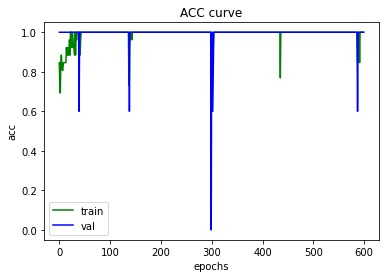

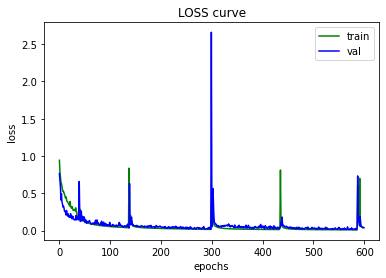

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
acc : t/v 0.8461538461538461 0.0
loss: t/v 0.9399196345072526 1.0803577303886414
acc : t/v 0.9230769230769231 0.6
loss: t/v 0.7599798716031588 0.8798109769821167
acc : t/v 0.9230769230769231 0.6
loss: t/v 0.6608243871193665 0.8641764998435975
acc : t/v 0.9230769230769231 0.6
loss: t/v 0.6035547176232705 0.8566941976547241
acc : t/v 0.9230769230769231 0.8
loss: t/v 0.5516239897562907 0.7627104759216309
acc : t/v 0.9230769230769231 0.8
loss: t/v 0.5277161437731522 0.7059054374694824
acc : t/v 0.9230769230769231 0.8
loss: t/v 0.4933638068345877 0.7752593040466309
acc : t/v 0.9230769230769231 0.8
loss: t/v 0.4667322521026318 0.6473233222961425
acc : t/v 0.9230769230769231 0.8
loss: t/v 0.44600923703267026 0.7735459446907044
acc : t/v 0.9230769230769231 0.2
loss: t/v 0.45196725542728716 0.9614821076393127
acc : t/v 0.9230769230769231 0.8
loss: t/v 0.41384310389940554 0.6985476970672607
acc : t/v 0.9230769230769231 0.8
loss: t/v 0.39427559077739716 0.7408

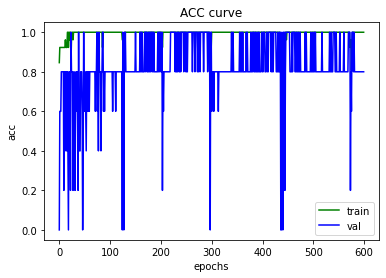

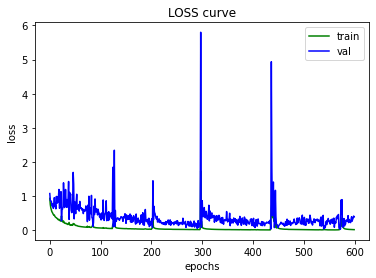

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
acc : t/v 0.6538461538461539 0.4
loss: t/v 1.0795299250345964 1.0373728156089783
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.8903688685252116 0.8714653491973877
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.798663562306991 0.8086076498031616
acc : t/v 0.7307692307692307 1.0
loss: t/v 0.7234184604424697 0.6420522570610047
acc : t/v 0.7307692307692307 1.0
loss: t/v 0.6636843176988455 0.5672475099563599
acc : t/v 0.7692307692307693 1.0
loss: t/v 0.6146950584191543 0.4864891588687897
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.5838857098267629 0.3701766014099121
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5661231164748852 0.3087497651576996
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.5315547814735999 0.34077147841453553
acc : t/v 0.9230769230769231 1.0
loss: t/v 0.5086316901903886 0.37163758277893066
acc : t/v 0.9230769230769231 1.0
loss: t/v 0.48542239918158603 0.34531023502349856
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.4938024076131674 0.41474

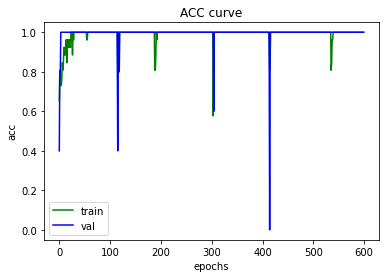

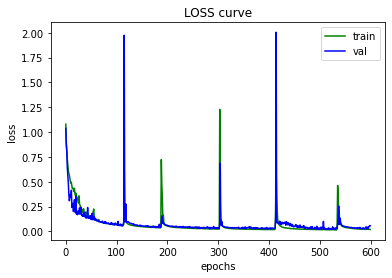

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
acc : t/v 0.8461538461538461 0.6
loss: t/v 0.920508439724262 0.9259400606155396
acc : t/v 0.8076923076923077 0.6
loss: t/v 0.7277281719904679 0.8115570902824402
acc : t/v 0.9230769230769231 1.0
loss: t/v 0.6081494688987732 0.5028547883033753
acc : t/v 0.9230769230769231 1.0
loss: t/v 0.5147491085987824 0.49574241042137146
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.4904758311234988 0.31913270354270934
acc : t/v 1.0 1.0
loss: t/v 0.3836432592226909 0.3341153562068939
acc : t/v 1.0 1.0
loss: t/v 0.32867929396721035 0.2945240199565887
acc : t/v 1.0 1.0
loss: t/v 0.29208056514079755 0.24173102974891664
acc : t/v 1.0 1.0
loss: t/v 0.2864729601603288 0.285269570350647
acc : t/v 1.0 1.0
loss: t/v 0.25194601198801625 0.25674061179161073
acc : t/v 1.0 1.0
loss: t/v 0.21694388871009535 0.21284834742546083
acc : t/v 1.0 1.0
loss: t/v 0.21129870185485253 0.24519275426864623
acc : t/v 1.0 1.0
loss: t/v 0.18913012742996216 0.19804114401340484
acc : t/v 1.0 1.0
l

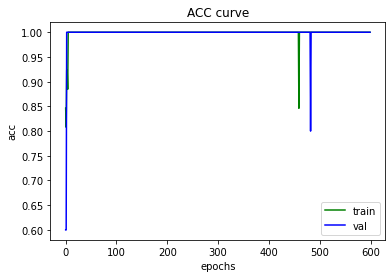

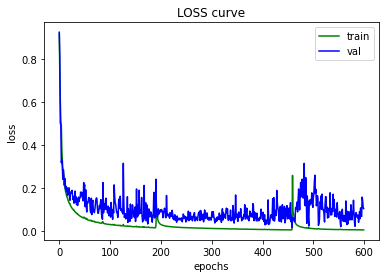

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
acc : t/v 0.7307692307692307 0.8
loss: t/v 0.8740543035360483 0.9931403756141662
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.7479224113317636 0.8592283725738525
acc : t/v 0.7692307692307693 0.8
loss: t/v 0.6683635448033993 0.7540014266967774
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.6380714178085327 0.743504548072815
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.5997328437291659 0.6866599321365356
acc : t/v 0.8076923076923077 0.6
loss: t/v 0.5853758007287979 0.8483350992202758
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5460204482078552 0.5100422978401185
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.5154401751664969 0.5999845385551452
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.4945042081750356 0.5229911029338836
acc : t/v 0.8076923076923077 0.6
loss: t/v 0.5146095380187035 0.7765988707542419
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.4967153863264964 0.5292971849441528
acc : t/v 0.8461538461538461 0.6
loss: t/v 0.4703296571969986 0.659916782

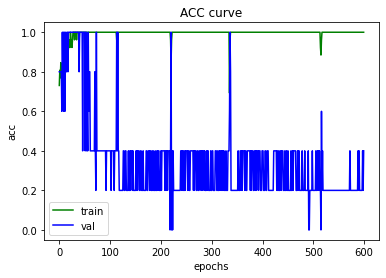

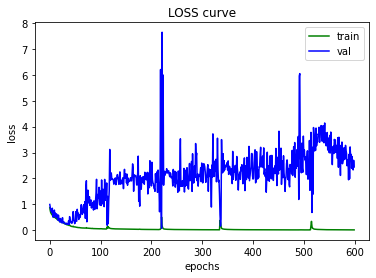

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:5
test size:4
acc : t/v 0.7037037037037037 1.0
loss: t/v 0.9951159578782541 0.762225353717804
acc : t/v 0.7407407407407407 1.0
loss: t/v 0.800154341591729 0.6006477832794189
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.6974440790988781 0.4786071002483368
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.6618953821835695 0.32510835528373716
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.6471109831774676 0.48956090211868286
acc : t/v 0.7777777777777778 1.0
loss: t/v 0.5858613120185004 0.3556091845035553
acc : t/v 0.8518518518518519 1.0
loss: t/v 0.5436391289587374 0.29403979480266573
acc : t/v 0.8518518518518519 1.0
loss: t/v 0.531784005187176 0.3145087629556656
acc : t/v 0.8518518518518519 1.0
loss: t/v 0.5089783712669655 0.28350751996040346
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.48672758760275664 0.2452167421579361
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.4631976258975488 0.2232040971517563
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.443720711602105 0.2456798

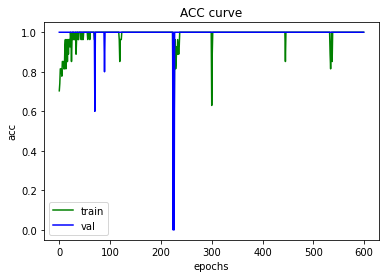

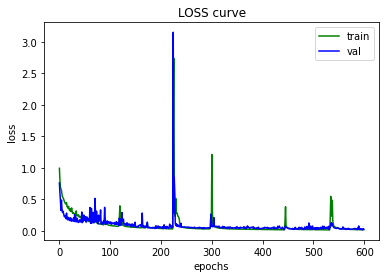

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:28
val size:5
test size:3
acc : t/v 0.8571428571428571 1.0
loss: t/v 0.9024306173835482 0.6225246667861939
acc : t/v 0.8928571428571429 1.0
loss: t/v 0.6888668441346714 0.5236220240592957
acc : t/v 0.9285714285714286 1.0
loss: t/v 0.5762215490852084 0.335973334312439
acc : t/v 0.9642857142857143 1.0
loss: t/v 0.5079105464475495 0.3140385329723358
acc : t/v 0.8928571428571429 1.0
loss: t/v 0.5020185336470604 0.26132733523845675
acc : t/v 0.9285714285714286 1.0
loss: t/v 0.48094654296125683 0.2938941687345505
acc : t/v 0.9285714285714286 1.0
loss: t/v 0.4450447697724615 0.22989144921302795
acc : t/v 0.9642857142857143 1.0
loss: t/v 0.40124830922910143 0.22456280291080474
acc : t/v 0.9285714285714286 1.0
loss: t/v 0.3854237331875733 0.20443159639835357
acc : t/v 0.9642857142857143 1.0
loss: t/v 0.3513464241155556 0.19384850859642028
acc : t/v 0.9642857142857143 1.0
loss: t/v 0.33833103626966476 0.1862660139799118
acc : t/v 1.0 1.0
loss: t/v 0.34024883593831745 0.187127998471260

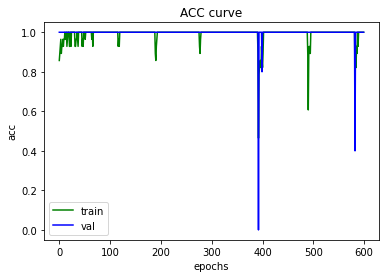

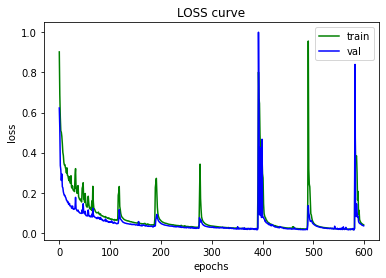

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:5
test size:4
acc : t/v 0.8518518518518519 1.0
loss: t/v 0.9006898822607817 0.6779783964157104
acc : t/v 0.8518518518518519 1.0
loss: t/v 0.7377101767946173 0.5680527091026306
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.6574986256934978 0.5010818183422089
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.6035175478016889 0.44731791615486144
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.5570406096952932 0.3215306580066681
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.516725073258082 0.33629143238067627
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.4839461412694719 0.29939694702625275
acc : t/v 0.8518518518518519 1.0
loss: t/v 0.5402576034819638 0.39609063863754274
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.45450233695683656 0.2892479807138443
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.42246038328718255 0.24420585930347444
acc : t/v 0.9629629629629629 1.0
loss: t/v 0.4154998373102259 0.28842238485813143
acc : t/v 0.9629629629629629 1.0
loss: t/v 0.3760438616629 0.2305

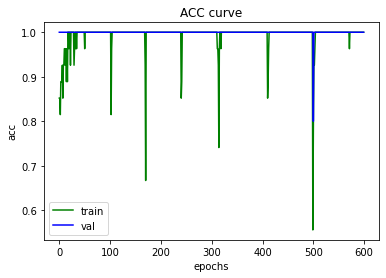

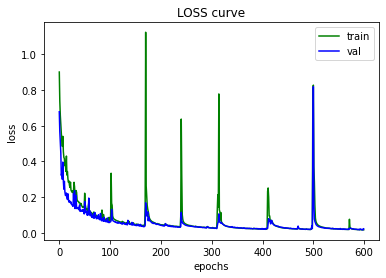

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

fold,iteration,macro,micro
6,0,0.5,0.4
3,0,0.5,1.0
4,0,0.5,1.0
5,0,0.0,0.0
2,0,0.5,1.0
1,0,0.5,1.0
7,0,0.0,0.0
8,0,0.5,1.0
total,total,0.6904761904761905,0.6944444444444444

      N     E
N  10.0   5.0
E   6.0  15.0
--- 7364.327666282654 seconds ---
End!


In [6]:
#Suturing reg = 0.0000001
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/Regroup_LOUO/'
nb_epochs = 600
print("epochs setting: ", nb_epochs)
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Knot_Tying'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
classes = ['N','E']
#classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 

#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)
validation_curve(surgery_type,reg = 0.00001,summary=False,max_itr=1)
#validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

In [0]:
#Drop out version
def each_dim_build_model(input_shapes,summary=True, reg=0.00001): 
	# get number of hands 
	num_hands= len(input_shapes)
	print(num_hands)
	# get number of dimensions cluster for each hand 
	num_dim_clusters = len(input_shapes[0])
	print(num_dim_clusters)
  # first index for hand second for  dims
	x =[[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# first conv layer on each dim cluster for each hand 
	conv1 = [[None for a in range(0,num_dim_clusters)]for b in range(num_hands)] 
	# merged layers for each hand 
	hand_layers =[None for a in range(num_hands)]
	# second conv layer on concatenated conv1 for each hand
	conv2 = [None for a in range(num_hands)] 
	# loop over each hand 
	for i in range(0,num_hands): 
		# loop for each hand over the dimension (or channels) clusters 
		for j in range(0,num_dim_clusters): 
			# input layer for each dimension cluster for each hand 
			x[i][j]=keras.layers.Input(input_shapes[i][j])
			# first conv layer over the clustered dimensions or channels in terms of keras 
			conv1[i][j] = keras.layers.Conv1D(8,kernel_size=3,strides=1,padding='same', activity_regularizer=regularizers.l2(reg))(x[i][j])
			conv1[i][j] = keras.layers.Activation('relu')(conv1[i][j])
		# concatenate convolutions of first layer over the channels dimension for each hand 
		hand_layers[i]=keras.layers.Concatenate(axis=-1)(conv1[i])
		# do a second convolution over features extracted from the first convolution over each hand 
		conv2[i] = keras.layers.Conv1D(16,kernel_size=3, strides=1, padding='same', activity_regularizer=regularizers.l2(reg))(hand_layers[i])
		conv2[i] = keras.layers.Activation('relu')(conv2[i])
	# concatenate the features of the two hands 
	final_input = keras.layers.Concatenate(axis=-1)(conv2) 
	# do a final convolution over the features concatenated for all hands 
	conv3 = keras.layers.Conv1D(32,kernel_size=3,strides=1,padding='same', activity_regularizer = regularizers.l2(reg))(final_input)
	conv3 = keras.layers.Activation('relu', name = "conv_final")(conv3)

	# do a globla average pooling of the final convolution 
	pooled = keras.layers.GlobalAveragePooling1D()(conv3)
 	#add drop out 
	drop = keras.layers.Dropout(0.5)(pooled)
	print("drop out")
	# add the final softmax classifier layer 
	out = keras.layers.Dense(nb_classes,activation='softmax')(drop)
	# create the model and link input to output 
	model = Model(inputs=list(chain.from_iterable(x)),outputs=out)
	# show summary if specified 
	if summary==True : 
		model.summary()
		print(model.summary())

	# choose the optimizer 
	optimizer = keras.optimizers.Adam()
	model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	return model

epochs setting:  600


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: loadtxt: Empty input file: "/content/drive/My Drive/Colab Notebooks/SDSProject/MyProject/Data/jigsaws/Knot_Tying/kinematics/AllGestures/Knot_Tying_H002.txt"


Number of different surgeries in total: 36
train size:26
val size:5
test size:5
4
5
drop out
acc : t/v 0.8076923076923077 1.0
loss: t/v 1.00506879733159 0.7714256048202515
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.8755110983665173 0.5650917172431946
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.7699815229727671 0.4973994970321655
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.7156657095138843 0.5262047708034515
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.6573456949912585 0.42277032136917114
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.6211451120101489 0.39006051421165466
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.5860522320637336 0.30712823271751405
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.5709630835514802 0.3501409411430359
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.542546156507272 0.2764087408781052
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5148723400556124 0.2666653960943222
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5004998376736274 0.22731779813766478
acc : t/v 0.846

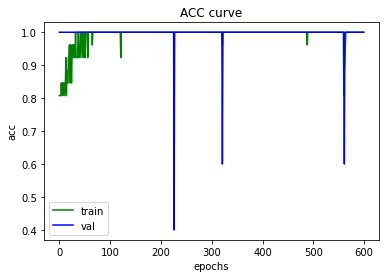

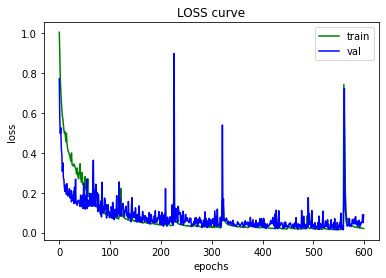

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
4
5
drop out
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.9530054812247937 1.213233435153961
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.7934431983874395 1.0102394104003907
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.6963553199401269 0.8670752763748169
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.6344978981293165 0.715148138999939
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.602826986175317 0.7234309077262878
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5695643872022629 0.6660052299499511
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5286536514759064 0.5803385317325592
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.5073498602096851 0.5451586008071899
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.4889807758422998 0.5827460646629333
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.4707182508248549 0.5574639678001404
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.4491762083310347 0.5354915618896484
acc : t/v 0.9230769230769231 1.0
loss: t/v 0.4318116198365505 

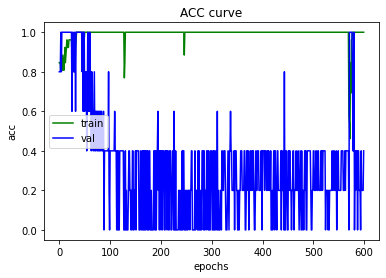

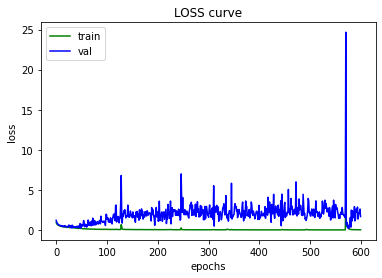

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
4
5
drop out
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.9699341975725614 1.113757109642029
acc : t/v 0.8076923076923077 0.6
loss: t/v 0.8491362058199369 1.0474971175193786
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.7441465224211032 0.921317994594574
acc : t/v 0.8461538461538461 0.6
loss: t/v 0.6913463438932712 0.8921609878540039
acc : t/v 0.8461538461538461 0.6
loss: t/v 0.6475123224350122 0.8366936206817627
acc : t/v 0.8461538461538461 0.6
loss: t/v 0.623705458182555 0.8292889833450318
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.5856005939153525 0.743592381477356
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.5706060700691663 0.6669068932533264
acc : t/v 0.8076923076923077 0.6
loss: t/v 0.5711218892381742 0.882812786102295
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.5430151579471735 0.5681366145610809
acc : t/v 0.8461538461538461 0.6
loss: t/v 0.5245508740727718 0.7596542835235596
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.49524529450214827 0

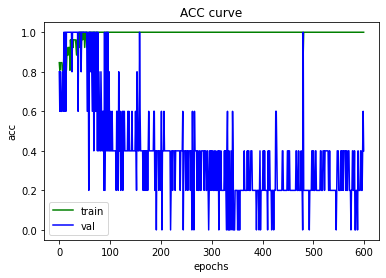

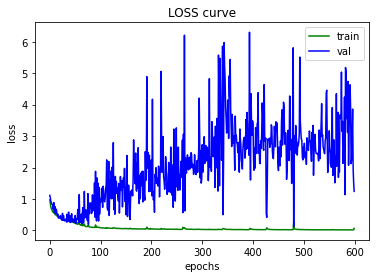

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
4
5
drop out
acc : t/v 0.7307692307692307 0.0
loss: t/v 1.0162927943926592 1.4478224039077758
acc : t/v 0.8076923076923077 0.6
loss: t/v 0.828934025305968 1.2274828553199768
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.7043825812064685 0.8732519626617432
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.624848220210809 0.8440534114837647
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.5617944804521707 0.7397295594215393
acc : t/v 0.8846153846153846 1.0
loss: t/v 0.5283392312435004 0.709668231010437
acc : t/v 0.9615384615384616 1.0
loss: t/v 0.47716445991626155 0.5347732543945313
acc : t/v 1.0 1.0
loss: t/v 0.4233375678841884 0.46332377195358276
acc : t/v 1.0 1.0
loss: t/v 0.38111923004572207 0.4769376516342163
acc : t/v 1.0 1.0
loss: t/v 0.34855852734584075 0.44006030559539794
acc : t/v 1.0 1.0
loss: t/v 0.32058237664974654 0.3764146089553833
acc : t/v 0.9615384615384616 1.0
loss: t/v 0.3527439230909714 0.5090976536273957
acc : t/v 0.9615384615384616 1.0
lo

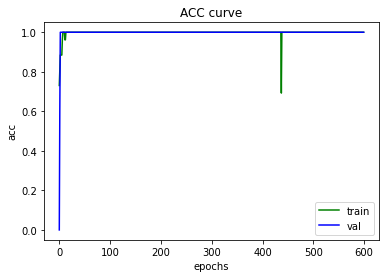

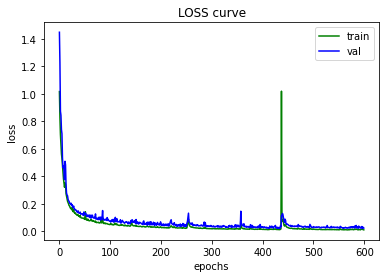

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:26
val size:5
test size:5
4
5
drop out
acc : t/v 0.7692307692307693 0.2
loss: t/v 0.9693822929492364 1.1495878934860229
acc : t/v 0.6923076923076923 0.8
loss: t/v 0.828632130072667 0.9022179484367371
acc : t/v 0.7692307692307693 0.8
loss: t/v 0.7422479104537231 0.8491366028785705
acc : t/v 0.6923076923076923 1.0
loss: t/v 0.6908181195075696 0.6707571387290955
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.6629523417124381 0.803638470172882
acc : t/v 0.7307692307692307 1.0
loss: t/v 0.6309778896661905 0.5807928740978241
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.5923246087936255 0.6521659135818482
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.5597739552076046 0.5420131802558898
acc : t/v 0.8461538461538461 1.0
loss: t/v 0.5490715262981561 0.5918343305587769
acc : t/v 0.8461538461538461 0.8
loss: t/v 0.5350184371838203 0.5973079860210418
acc : t/v 0.8076923076923077 1.0
loss: t/v 0.507598839700222 0.5547089219093323
acc : t/v 0.8076923076923077 0.8
loss: t/v 0.5014730806534107 

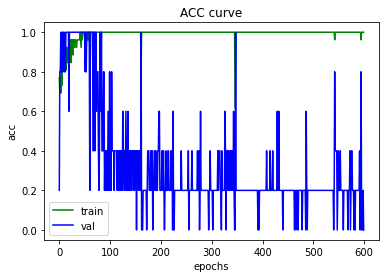

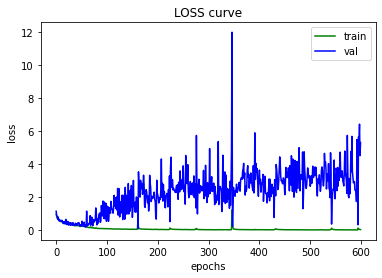

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:5
test size:4
4
5
drop out
acc : t/v 0.7407407407407407 0.0
loss: t/v 0.8864725254200123 1.4464087724685668
acc : t/v 0.7777777777777778 0.2
loss: t/v 0.7296290187923996 1.2263460636138916
acc : t/v 0.8148148148148148 0.6
loss: t/v 0.6626752493558107 1.0788848161697389
acc : t/v 0.7777777777777778 0.8
loss: t/v 0.6053540474838681 0.8938098430633545
acc : t/v 0.7777777777777778 0.8
loss: t/v 0.5782947794154838 0.849193024635315
acc : t/v 0.8148148148148148 0.6
loss: t/v 0.548321145552176 0.8910032391548157
acc : t/v 0.7777777777777778 0.6
loss: t/v 0.5285484685941979 0.8191005825996399
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.4992902610037062 0.7021034240722657
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.4862516086410593 0.7211400866508484
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.46503902364660193 0.6552951574325562
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.45350345803631675 0.5575410068035126
acc : t/v 0.8148148148148148 1.0
loss: t/v 0.43861027834592

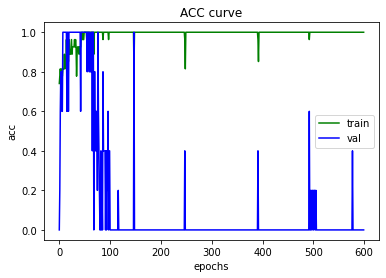

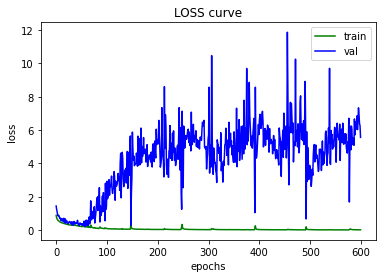

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:28
val size:5
test size:3
4
5
drop out
acc : t/v 0.7142857142857143 0.0
loss: t/v 0.8244973708476339 1.4485013961791993
acc : t/v 0.8214285714285714 0.0
loss: t/v 0.6856616458722523 1.2627884864807128
acc : t/v 0.9285714285714286 0.6
loss: t/v 0.5716953767197472 1.0357655882835388
acc : t/v 0.9285714285714286 0.8
loss: t/v 0.5112121094550405 0.9237631559371948
acc : t/v 0.9285714285714286 0.6
loss: t/v 0.47418320711169926 0.9577606916427612
acc : t/v 0.9285714285714286 0.8
loss: t/v 0.4519962838717869 0.8046079754829407
acc : t/v 0.9285714285714286 0.6
loss: t/v 0.41766063815781046 0.8467371463775635
acc : t/v 0.9285714285714286 0.8
loss: t/v 0.3934221182550703 0.7081056833267212
acc : t/v 0.8928571428571429 1.0
loss: t/v 0.4034654327801296 0.530525416135788
acc : t/v 0.9285714285714286 0.8
loss: t/v 0.36337087942021234 0.6990613460540771
acc : t/v 0.9285714285714286 0.8
loss: t/v 0.355422280728817 0.7074495315551758
acc : t/v 0.9285714285714286 0.8
loss: t/v 0.3521302395633

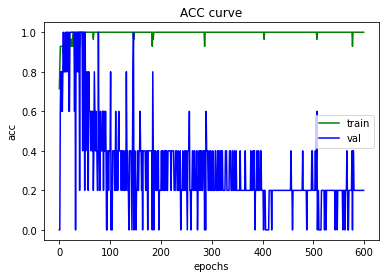

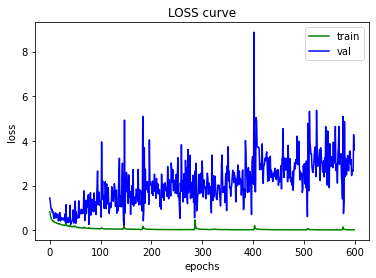

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:5
test size:4
4
5
drop out
acc : t/v 0.7777777777777778 0.0
loss: t/v 0.9223017714641712 1.7544936656951904
acc : t/v 0.8888888888888888 0.0
loss: t/v 0.7611373949933935 1.4911181688308717
acc : t/v 0.8888888888888888 0.0
loss: t/v 0.6493405390668798 1.4386795997619628
acc : t/v 0.8888888888888888 0.4
loss: t/v 0.5702475872304704 1.2574525594711303
acc : t/v 0.9259259259259259 0.4
loss: t/v 0.53239897997291 1.095934021472931
acc : t/v 0.8888888888888888 0.2
loss: t/v 0.49587012441069994 1.281518042087555
acc : t/v 0.9259259259259259 0.4
loss: t/v 0.45961294019663773 1.2854295730590821
acc : t/v 0.9259259259259259 0.4
loss: t/v 0.425129027278335 1.2647965908050538
acc : t/v 0.9259259259259259 0.4
loss: t/v 0.39679295431684564 1.1380982398986816
acc : t/v 0.9259259259259259 0.4
loss: t/v 0.381165384694382 1.3084195971488952
acc : t/v 0.9259259259259259 0.4
loss: t/v 0.3588023014642574 1.3406235218048095
acc : t/v 0.9259259259259259 0.2
loss: t/v 0.3299047334326638 

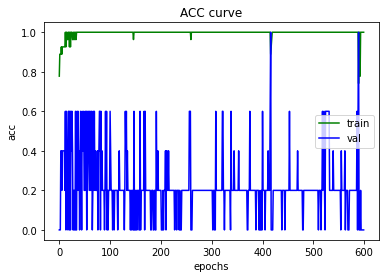

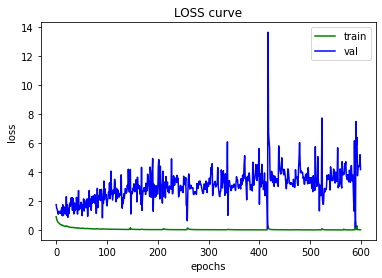

fold,iteration,macro,micro
6,0,0.5,0.2
3,0,0.5,1.0
4,0,0.5,1.0
5,0,0.0,0.0
2,0,0.5,1.0
1,0,0.5,1.0
7,0,0.5,1.0
8,0,0.5,1.0
total,total,0.7476780185758514,0.75

      N     E
N  12.0   5.0
E   4.0  15.0
--- 11389.367075443268 seconds ---
End!


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [0]:
#Knot-Tying with drop out 600 epochs drop 0.3 fully before
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/Regroup_LOUO/'
nb_epochs = 600
print("epochs setting: ", nb_epochs)
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Knot_Tying'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
classes = ['N','E']
#classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 

#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)
validation_curve(surgery_type,reg = 0.00001,summary=False,max_itr=1)
#validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

epochs setting:  600


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: loadtxt: Empty input file: "/content/drive/My Drive/Colab Notebooks/SDSProject/MyProject/Data/jigsaws/Knot_Tying/kinematics/AllGestures/Knot_Tying_H002.txt"


Number of different surgeries in total: 36
train size:27
val size:4
test size:5
4
5




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








acc : t/v 0.8148148148148148 0.0
loss: t/v 0.8510539774541501 1.3885278701782227
acc : t/v 0.8518518518518519 0.0
loss: t/v 0.6731709120450197 1.7698904871940613
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.5970833776173768 1.0993252396583557
acc : t/v 0.8888888888888888 0.25
loss: t/v 0.5145922159707105 1.679226964712143
acc : t/v 0.9259259259259259 0.25
loss: t/v 0.46004068630713 1.4637641310691833
acc : t/v 0.9259259259259259 0.25
loss: t/v 0.431590105648394 1.6155377924442291
acc : t/v 0.9629629629629629 0.5
loss: t/v 0.44255161726916276 1.0845151543617249
acc : t/v 0.9259259259259259 0.0
loss: t/v 0.41343329736480006 2.161871999502182
acc : t/v 0.9259259259259259 0.25
loss: t/v 0

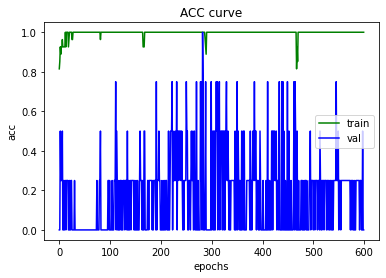

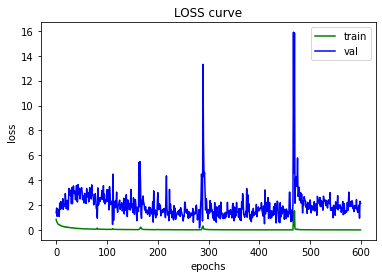

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:4
test size:5
4
5
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.8823932056073789 1.1194804310798645
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.7018888802440079 0.9178971499204636
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.6248879256071868 0.8562233746051788
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.5511575959346913 0.8678695857524872
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.5024775553632665 0.7238901108503342
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.47086262868510353 0.8764065876603127
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.43091705441474915 0.8055864349007607
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.41602496637238395 0.8919786512851715
acc : t/v 1.0 0.5
loss: t/v 0.38607882570337365 0.7264804691076279
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.41940132280190784 0.5007030591368675
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.3745349469008269 0.9334970414638519
acc : t/v 0.9629629629629629 0.75
loss: t/v 0.39411989516682094 0.507572382688

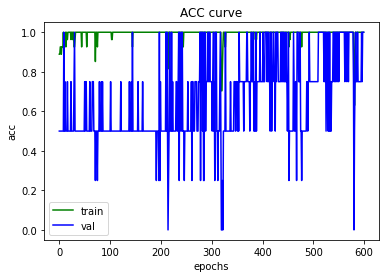

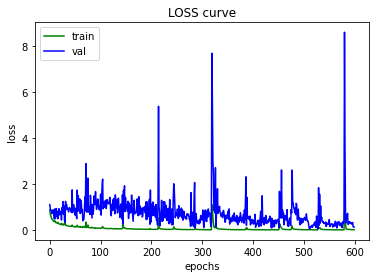

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:4
test size:5
4
5
acc : t/v 0.8148148148148148 0.5
loss: t/v 0.9150726397832235 1.3429043591022491
acc : t/v 0.8518518518518519 0.5
loss: t/v 0.7599023381868998 1.2557778507471085
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.6684094016198758 1.1473369598388672
acc : t/v 0.8518518518518519 0.5
loss: t/v 0.6228774134759549 0.8729608356952667
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.5941372293013113 0.820371001958847
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.5581410604494589 1.1890720427036285
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.5193134193067197 0.8006972000002861
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.48862362183906416 1.0267510265111923
acc : t/v 0.9259259259259259 0.75
loss: t/v 0.513679254938055 0.6261518746614456
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.4498603614392104 0.7878391966223717
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.433491043470524 1.0323822051286697
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.4065362689671693 0.89871

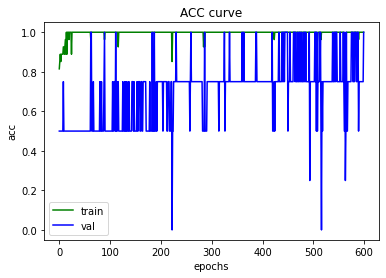

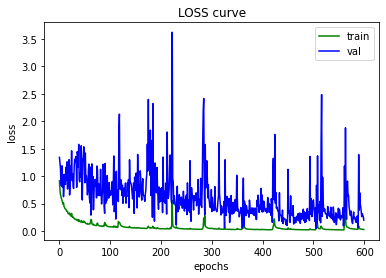

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:4
test size:5
4
5
acc : t/v 0.8518518518518519 0.5
loss: t/v 0.9291618907893145 1.1946951150894165
acc : t/v 0.8888888888888888 0.75
loss: t/v 0.7161806016056625 0.9660034030675888
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.5955722022939611 0.7199682146310806
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.512356553916578 0.6596421003341675
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.4584880901707543 0.6246031895279884
acc : t/v 1.0 1.0
loss: t/v 0.41123936849611775 0.4544047564268112
acc : t/v 0.9259259259259259 1.0
loss: t/v 0.4069684550718025 0.5725624933838844
acc : t/v 0.9629629629629629 1.0
loss: t/v 0.38162475382840194 0.3853072375059128
acc : t/v 1.0 1.0
loss: t/v 0.2972588721248839 0.38822148740291595
acc : t/v 1.0 1.0
loss: t/v 0.29270699178731 0.40494731813669205
acc : t/v 1.0 1.0
loss: t/v 0.25071877351513616 0.34422462433576584
acc : t/v 1.0 1.0
loss: t/v 0.2651389666177608 0.3159434348344803
acc : t/v 1.0 1.0
loss: t/v 0.21923518787931512 0.29477486

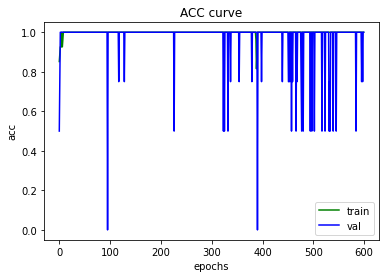

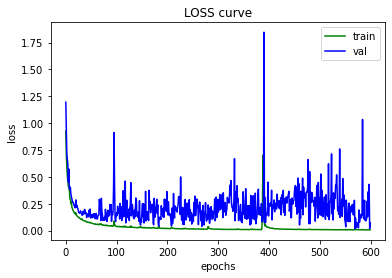

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:4
test size:5
4
5
acc : t/v 0.8518518518518519 0.5
loss: t/v 0.971067053300363 1.2575171291828156
acc : t/v 0.8148148148148148 0.5
loss: t/v 0.8107383096659625 1.1883020550012589
acc : t/v 0.8148148148148148 0.5
loss: t/v 0.7238485426814468 0.8711907118558884
acc : t/v 0.8518518518518519 0.5
loss: t/v 0.6520309624848543 1.0928768962621689
acc : t/v 0.8148148148148148 0.5
loss: t/v 0.6308236983087327 1.2305568754673004
acc : t/v 0.8518518518518519 0.5
loss: t/v 0.5748979217476315 0.7984177395701408
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.5209445224867927 0.9714629277586937
acc : t/v 0.9259259259259259 0.5
loss: t/v 0.5089055101076762 0.7455177381634712
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.474323116518833 1.0547015443444252
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.4654970759594882 0.7466799542307854
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.46401630617954115 0.9682507887482643
acc : t/v 0.8888888888888888 0.5
loss: t/v 0.426856161819564 1.018055

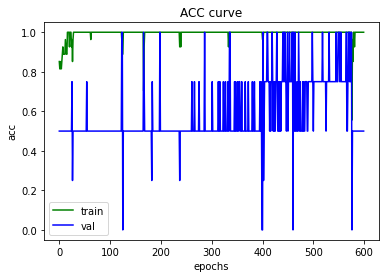

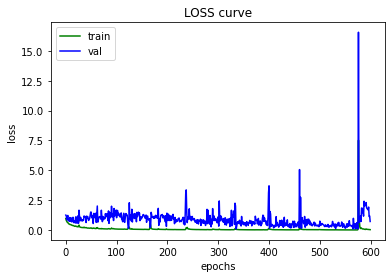

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:28
val size:4
test size:4
4
5
acc : t/v 0.7142857142857143 0.0
loss: t/v 0.9724560294832502 1.6576232612133026
acc : t/v 0.75 0.25
loss: t/v 0.788743294775486 1.2119615077972412
acc : t/v 0.8928571428571429 0.5
loss: t/v 0.6942605578473636 1.0151281952857971
acc : t/v 0.8571428571428571 0.5
loss: t/v 0.6039117670484951 0.8303899466991425
acc : t/v 0.8928571428571429 0.5
loss: t/v 0.5375364204602582 1.0318825989961624
acc : t/v 0.8571428571428571 0.5
loss: t/v 0.5061044469475746 0.7940628230571747
acc : t/v 0.8928571428571429 0.5
loss: t/v 0.48076656247888294 1.0388441756367683
acc : t/v 0.8928571428571429 0.5
loss: t/v 0.4836618682103498 0.7118245512247086
acc : t/v 0.8928571428571429 0.5
loss: t/v 0.43607921791928156 1.0178876593708992
acc : t/v 0.9285714285714286 0.5
loss: t/v 0.40981651310409817 0.9844682887196541
acc : t/v 0.9642857142857143 0.5
loss: t/v 0.44047386412109646 0.6942288130521774
acc : t/v 0.8571428571428571 0.5
loss: t/v 0.48360325183187214 1.6124913543462

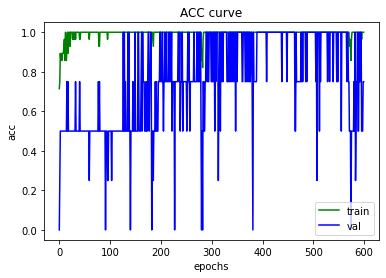

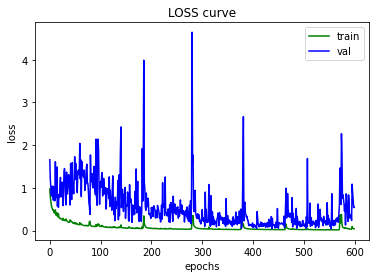

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:29
val size:4
test size:3
4
5
acc : t/v 0.7586206896551724 0.0
loss: t/v 0.7681543816780222 1.721508264541626
acc : t/v 0.9655172413793104 0.5
loss: t/v 0.572165342240498 1.1698839366436005
acc : t/v 0.9655172413793104 0.5
loss: t/v 0.4696931515274377 1.2641425281763077
acc : t/v 0.9310344827586207 0.5
loss: t/v 0.4499046113984338 1.5211761146783829
acc : t/v 1.0 0.5
loss: t/v 0.39284849012720174 0.8357397019863129
acc : t/v 0.9655172413793104 0.5
loss: t/v 0.34730416176647977 1.0714795514941216
acc : t/v 1.0 0.5
loss: t/v 0.31667845002536116 1.0210167467594147
acc : t/v 0.9655172413793104 0.5
loss: t/v 0.34765077099717895 0.6974302902817726
acc : t/v 0.9655172413793104 0.5
loss: t/v 0.28900955617427826 1.1579818800091743
acc : t/v 1.0 0.5
loss: t/v 0.27272697666595724 0.8729908168315887
acc : t/v 1.0 0.5
loss: t/v 0.2710592032506548 0.8212195187807083
acc : t/v 0.9655172413793104 0.5
loss: t/v 0.28113088705416384 1.3797116726636887
acc : t/v 1.0 0.5
loss: t/v 0.241711789677

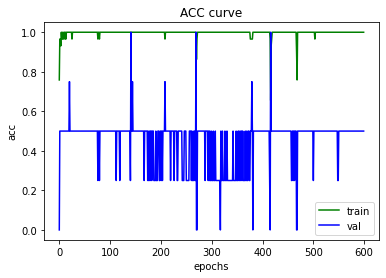

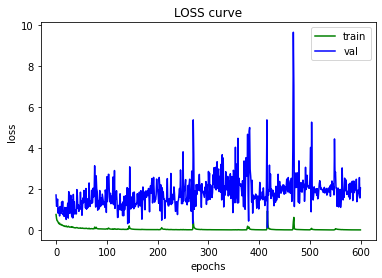

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:27
val size:5
test size:4
4
5
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.8691338433159722 0.7837223887443543
acc : t/v 0.8888888888888888 0.6
loss: t/v 0.7298034893141853 0.9370316863059998
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.661902912237026 0.5497794926166535
acc : t/v 0.9259259259259259 0.6
loss: t/v 0.5763310160901811 0.7764274120330811
acc : t/v 0.9259259259259259 0.6
loss: t/v 0.5366682509581248 0.8453912734985352
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.5274993589630833 0.46780296564102175
acc : t/v 0.9259259259259259 0.6
loss: t/v 0.46975296515005605 0.6799667775630951
acc : t/v 0.9629629629629629 0.6
loss: t/v 0.4465558964897085 0.8152413249015809
acc : t/v 0.8888888888888888 0.8
loss: t/v 0.43201756201408525 0.48976301550865176
acc : t/v 1.0 0.6
loss: t/v 0.4099123141279927 0.9653660118579864
acc : t/v 1.0 0.6
loss: t/v 0.37681620485252804 0.8159287333488464
acc : t/v 1.0 0.6
loss: t/v 0.36981979067678805 0.7784876823425293
acc : t/v 0.888888888888888

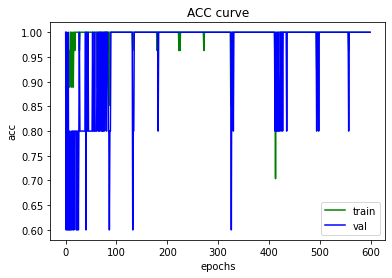

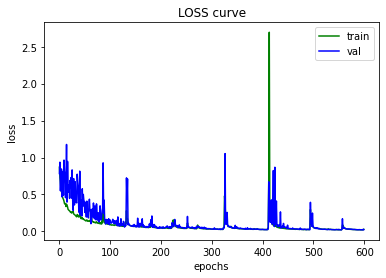

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

fold,iteration,macro,micro
6,0,0.5,0.6
3,0,0.5,0.8
4,0,0.5,1.0
5,0,0.0,0.0
2,0,0.5,1.0
1,0,0.5,1.0
7,0,0.5,1.0
8,0,0.5,1.0
total,total,0.7875,0.7777777777777778

      N     E
N  14.0   6.0
E   2.0  14.0
--- 6021.737345218658 seconds ---
End!


In [0]:
#Knot-Tying with drop out 600 epochs
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/Regroup_LOUO/'
nb_epochs = 600
print("epochs setting: ", nb_epochs)
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Knot_Tying'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
classes = ['N','E']
#classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 

#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)
validation_curve(surgery_type,reg = 0.00001,summary=False,max_itr=1)
#validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

In [0]:
#Knot-Tying with drop out 1000 epochs
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/Regroup_LOUO/'
nb_epochs = 1000
print("epochs setting: ", nb_epochs)
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Knot_Tying'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
classes = ['N','E']
#classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 

#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)
validation_curve(surgery_type,reg = 0.00001,summary=False,max_itr=1)
#validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

In [0]:
#Knot-Tying with no drop out
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/Regroup_LOUO/'
nb_epochs = 600
print("epochs setting: ", nb_epochs)
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Knot_Tying'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
classes = ['N','E']
#classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 

#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)
validation_curve(surgery_type,reg = 0.00001,summary=False,max_itr=1)
#validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

epochs setting:  600


KeyboardInterrupt: ignored

epochs setting:  1000
Number of different surgeries in total: 39
train size:30
val size:5
test size:4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

acc : t/v 0.6333333333333333 0.0
loss: t/v 1.2515355825424195 1.3240469694137573
acc : t/v 0.7 0.2
loss: t/v 1.010104270776113 1.1357336044311523
acc : t/v 0.7666666666666667 1.0
loss: t/v 0.868831314643224 0.8431217670440674
acc : t/v 0.7 1.0
loss: t/v 0.8088791777690252 0.7079632997512817
acc : t/v 0.8 0.4
loss: t/v 0.7148658802111943 0.9805776357650757
acc : t/v 0.9333333333333333 1.0
loss: t/v 0.6432798753182093 0.6263022661209107
acc : t/v 0.9 0.8
loss: t/v 0.6004405528306961 0.8460683703422547
acc : t/v 1.0 1.0
loss: t/v 0.545661527911822 0.5670996189117432
acc : t/v 1.0 1.0
loss: t/v 0.5091572393973668 0.4862035632133484
acc : t/v 0.8666666666666667 1.0
loss: t/v 0.49955746680498125 0.7041182160377503
acc : t/v 1.0 1.0
loss: t/v 0.4201092213392258 0.6069211006164551
acc : t/v 1.0 1.0
loss: t/v 0.39

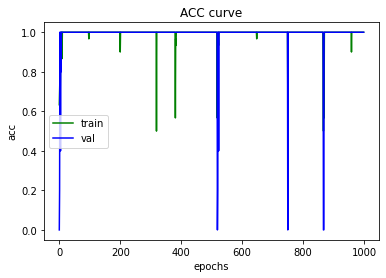

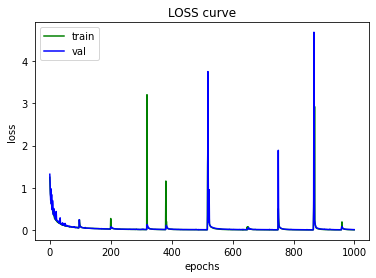

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:30
val size:4
test size:5
acc : t/v 0.8666666666666667 0.25
loss: t/v 1.149886417388916 1.7362943291664124
acc : t/v 0.9666666666666667 0.25
loss: t/v 0.8816351970036824 1.5350814163684845
acc : t/v 0.9666666666666667 0.25
loss: t/v 0.7160326331853867 1.5939997434616089
acc : t/v 0.9666666666666667 0.25
loss: t/v 0.6213242322206497 1.563089981675148
acc : t/v 1.0 0.25
loss: t/v 0.5622235427300135 1.2976787984371185
acc : t/v 0.9333333333333333 0.25
loss: t/v 0.5176706910133362 1.7970393896102905
acc : t/v 0.9666666666666667 0.25
loss: t/v 0.43455876658360165 1.4930264800786972
acc : t/v 1.0 0.25
loss: t/v 0.4166286418835322 1.1938984841108322
acc : t/v 1.0 0.25
loss: t/v 0.3804064889748891 1.0626793652772903
acc : t/v 1.0 0.25
loss: t/v 0.3384569634993871 1.3812879174947739
acc : t/v 0.9666666666666667 0.25
loss: t/v 0.34144868155320485 1.7397636473178864
acc : t/v 1.0 0.25
loss: t/v 0.3071959286928177 1.374478355050087
acc : t/v 1.0 0.25
loss: t/v 0.2856648008028666 1.00730

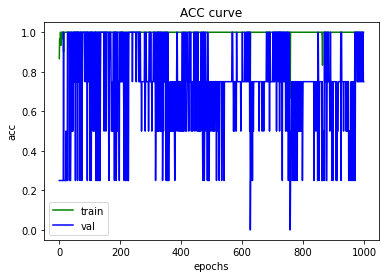

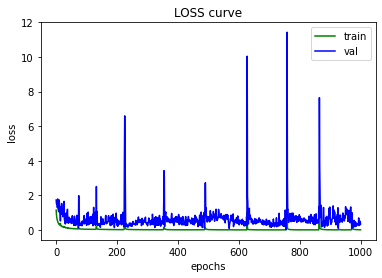

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:30
val size:4
test size:5
acc : t/v 0.7333333333333333 1.0
loss: t/v 1.3553349256515503 1.4882732927799225
acc : t/v 0.6666666666666666 1.0
loss: t/v 1.0914882361888885 1.182180643081665
acc : t/v 0.8333333333333334 1.0
loss: t/v 0.9402975022792817 1.0256073325872421
acc : t/v 0.8333333333333334 0.25
loss: t/v 0.8391466101010641 1.037643477320671
acc : t/v 0.8333333333333334 1.0
loss: t/v 0.7529914855957032 0.8939599394798279
acc : t/v 0.8666666666666667 1.0
loss: t/v 0.699088740348816 0.7506378144025803
acc : t/v 0.8666666666666667 1.0
loss: t/v 0.6707197805245717 0.6200201064348221
acc : t/v 0.9666666666666667 1.0
loss: t/v 0.5575651884078979 0.7518685460090637
acc : t/v 0.9666666666666667 1.0
loss: t/v 0.5126913299163183 0.7581762373447418
acc : t/v 1.0 1.0
loss: t/v 0.462598592042923 0.6557793766260147
acc : t/v 0.9 1.0
loss: t/v 0.49248894602060317 0.47758210450410843
acc : t/v 0.9333333333333333 0.75
loss: t/v 0.47935939927895865 0.8550264239311218
acc : t/v 1.0 1.0
lo

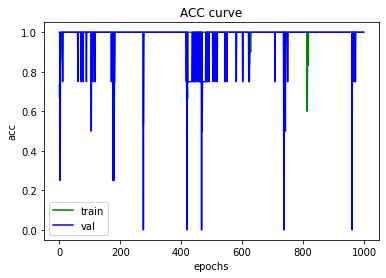

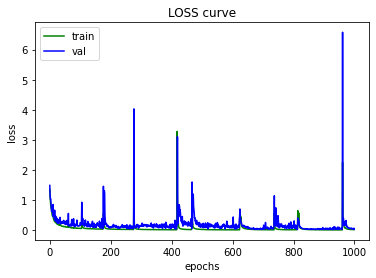

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:30
val size:4
test size:5
acc : t/v 0.7 0.25
loss: t/v 1.2233841220537822 1.3846253752708435
acc : t/v 0.7333333333333333 0.25
loss: t/v 0.9848509788513183 1.1933204233646393
acc : t/v 0.8333333333333334 0.75
loss: t/v 0.8604892432689667 0.9921405464410782
acc : t/v 0.8666666666666667 1.0
loss: t/v 0.7362223704655965 0.8634037524461746
acc : t/v 0.8333333333333334 0.5
loss: t/v 0.6744867483774821 0.9530291855335236
acc : t/v 0.9 1.0
loss: t/v 0.5707893610000611 0.6015525311231613
acc : t/v 0.9 1.0
loss: t/v 0.4870387723048528 0.4888530299067497
acc : t/v 1.0 1.0
loss: t/v 0.3889658848444621 0.4376564025878906
acc : t/v 0.9 1.0
loss: t/v 0.43112795104583107 0.6429035067558289
acc : t/v 1.0 1.0
loss: t/v 0.3062234938144684 0.3641861453652382
acc : t/v 1.0 1.0
loss: t/v 0.29425915628671645 0.3865051716566086
acc : t/v 1.0 1.0
loss: t/v 0.2564506158232689 0.3165757432579994
acc : t/v 1.0 1.0
loss: t/v 0.2606051420172056 0.36293763667345047
acc : t/v 1.0 1.0
loss: t/v 0.226861739

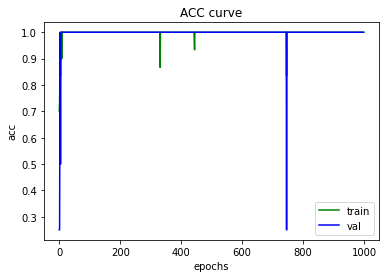

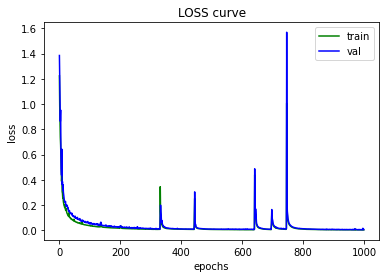

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:30
val size:4
test size:5
acc : t/v 0.8 1.0
loss: t/v 1.2660911460717519 1.4484908282756805
acc : t/v 0.8333333333333334 0.75
loss: t/v 0.9706006586551666 1.2616356313228607
acc : t/v 0.9333333333333333 1.0
loss: t/v 0.7927464524904887 0.882224440574646
acc : t/v 0.9 1.0
loss: t/v 0.6844856202602386 0.6912941634654999
acc : t/v 1.0 1.0
loss: t/v 0.5698763986428579 0.7534315139055252
acc : t/v 1.0 1.0
loss: t/v 0.5364688764015834 0.7548947036266327
acc : t/v 1.0 1.0
loss: t/v 0.44981789191563926 0.5646774023771286
acc : t/v 1.0 1.0
loss: t/v 0.4092886964480082 0.5108457952737808
acc : t/v 1.0 1.0
loss: t/v 0.38003646632035576 0.44003184139728546
acc : t/v 1.0 1.0
loss: t/v 0.36504953900973003 0.49365511536598206
acc : t/v 1.0 1.0
loss: t/v 0.34143101622660954 0.3718781992793083
acc : t/v 0.9666666666666667 1.0
loss: t/v 0.3763017773628235 0.5875815078616142
acc : t/v 1.0 1.0
loss: t/v 0.2987744043270747 0.3609127476811409
acc : t/v 1.0 1.0
loss: t/v 0.285362675289313 0.377871

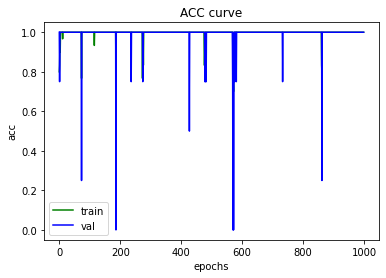

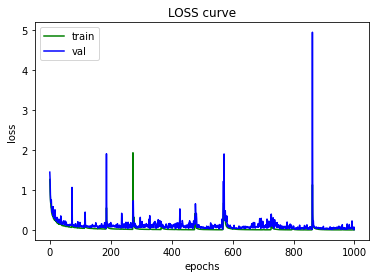

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:30
val size:4
test size:5
acc : t/v 0.6666666666666666 0.0
loss: t/v 1.1866524994373322 1.661300390958786
acc : t/v 0.6666666666666666 0.0
loss: t/v 0.9381104588508606 1.469097763299942
acc : t/v 0.6666666666666666 0.0
loss: t/v 0.8194091429313024 1.4635047316551208
acc : t/v 0.6666666666666666 0.0
loss: t/v 0.7182081560293834 1.145265519618988
acc : t/v 0.6666666666666666 0.0
loss: t/v 0.6695250997940699 1.1983901858329773
acc : t/v 0.9666666666666667 1.0
loss: t/v 0.5746728658676148 0.8634275943040848
acc : t/v 0.9 1.0
loss: t/v 0.6241567919651667 0.711572602391243
acc : t/v 0.9666666666666667 1.0
loss: t/v 0.5034964720408122 0.7397023588418961
acc : t/v 0.9 1.0
loss: t/v 0.5390421057740847 0.5150661319494247
acc : t/v 1.0 1.0
loss: t/v 0.4258601407210032 0.5854672715067863
acc : t/v 1.0 1.0
loss: t/v 0.40025220761696495 0.5719970017671585
acc : t/v 1.0 1.0
loss: t/v 0.3770811726649602 0.4772229790687561
acc : t/v 0.9 0.75
loss: t/v 0.4208177720506986 0.8519606292247772
ac

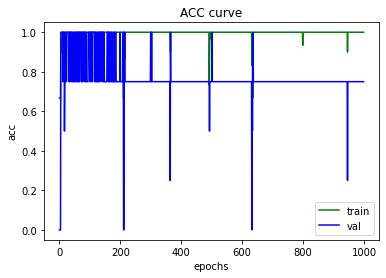

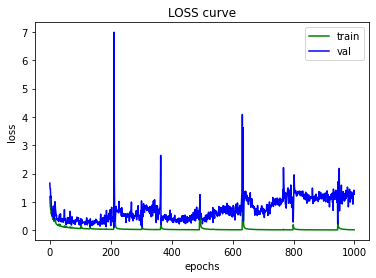

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:30
val size:4
test size:5
acc : t/v 0.6666666666666666 0.0
loss: t/v 1.2378452360630035 1.5084679424762726
acc : t/v 0.7 0.25
loss: t/v 0.9632075488567352 1.2501607239246368
acc : t/v 0.9 1.0
loss: t/v 0.8107693453629812 0.9957085847854614
acc : t/v 0.9333333333333333 0.75
loss: t/v 0.7026146362225215 0.94722780585289
acc : t/v 0.9333333333333333 1.0
loss: t/v 0.6277766903241475 0.8398540169000626
acc : t/v 0.9 1.0
loss: t/v 0.6133892446756363 0.7471776455640793
acc : t/v 0.8666666666666667 0.5
loss: t/v 0.5706203018625577 0.8929290473461151
acc : t/v 1.0 1.0
loss: t/v 0.5121153950691223 0.6992626041173935
acc : t/v 1.0 1.0
loss: t/v 0.4689101854960124 0.6055355817079544
acc : t/v 0.9333333333333333 1.0
loss: t/v 0.4784090340137482 0.5204940959811211
acc : t/v 0.9666666666666667 1.0
loss: t/v 0.4276662180821101 0.5089462324976921
acc : t/v 1.0 1.0
loss: t/v 0.38941115389267605 0.49475719779729843
acc : t/v 0.8 0.25
loss: t/v 0.5280403405427933 0.9224812835454941
acc : t/v 0.

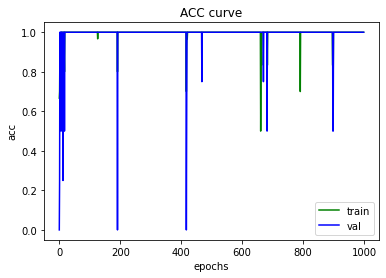

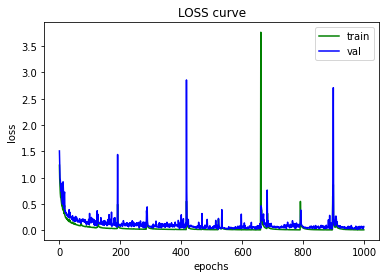

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:30
val size:4
test size:5
acc : t/v 0.7 0.0
loss: t/v 1.1901913225650786 1.8562543094158173
acc : t/v 0.8333333333333334 0.25
loss: t/v 0.9577226301034292 1.440937727689743
acc : t/v 0.7666666666666667 0.0
loss: t/v 0.8117351402839025 1.6423707604408264
acc : t/v 0.8333333333333334 0.25
loss: t/v 0.6972137928009033 1.2705723643302917
acc : t/v 0.7666666666666667 0.0
loss: t/v 0.6518298457066218 1.372963398694992
acc : t/v 0.8666666666666667 0.25
loss: t/v 0.5677633946140607 1.1667076647281647
acc : t/v 0.9333333333333333 0.5
loss: t/v 0.5010202114780744 0.9896875768899918
acc : t/v 0.9666666666666667 0.5
loss: t/v 0.4516987512509028 0.9907531589269638
acc : t/v 1.0 1.0
loss: t/v 0.42839520871639253 0.5890259742736816
acc : t/v 1.0 1.0
loss: t/v 0.44526884108781817 0.48650114983320236
acc : t/v 1.0 1.0
loss: t/v 0.4309133897225062 0.5111328512430191
acc : t/v 1.0 1.0
loss: t/v 0.35505973200003305 0.49873609840869904
acc : t/v 1.0 1.0
loss: t/v 0.34178280979394915 0.4779405072

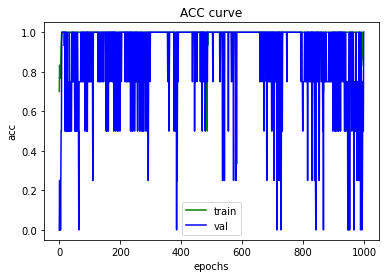

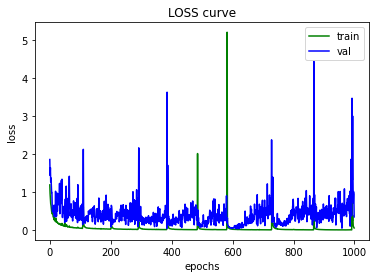

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

fold,iteration,macro,micro
7,0,0.5,1.0
8,0,0.5,1.0
3,0,0.5,1.0
5,0,0.0,0.0
2,0,0.5,0.4
6,0,0.5,1.0
4,0,0.5,1.0
1,0,0.5,1.0
total,total,0.8518518518518519,0.7948717948717948

      N     E
N  19.0   8.0
E   0.0  12.0
--- 21028.275898218155 seconds ---
End!


In [0]:
#Suturing with drop out
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/Regroup_LOUO/'
nb_epochs = 1000
print("epochs setting: ", nb_epochs)
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Suturing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
classes = ['N','E']
#classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 

#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)
validation_curve(surgery_type,reg = 0.00001,summary=False,max_itr=1)
#validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

epochs setting:  600
Number of different surgeries in total: 28
train size:18
val size:5
test size:4
acc : t/v 0.6666666666666666 1.0
loss: t/v 1.2857304910818736 1.1524254202842712
acc : t/v 0.6666666666666666 1.0
loss: t/v 1.0859505699740515 0.986422598361969
acc : t/v 0.6666666666666666 1.0
loss: t/v 0.9545833468437195 0.8416293978691101
acc : t/v 0.6666666666666666 1.0
loss: t/v 0.8644987940788269 0.7139325499534607
acc : t/v 0.7222222222222222 1.0
loss: t/v 0.8061764637629191 0.7128003478050232
acc : t/v 0.6666666666666666 1.0
loss: t/v 0.7522810581657622 0.5790007829666137
acc : t/v 0.8333333333333334 1.0
loss: t/v 0.7039331114954419 0.6007829129695892
acc : t/v 0.7222222222222222 1.0
loss: t/v 0.667886366446813 0.5093450009822845
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.6286413388119804 0.5469272494316101
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.5899722675482432 0.483675479888916
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.5577001803451114 0.4804524898529053
acc : t/v 0

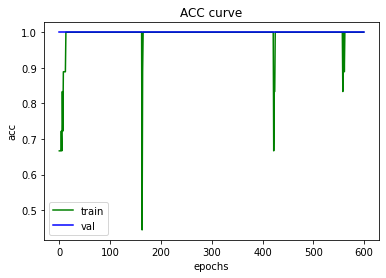

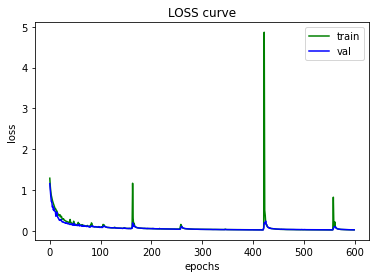

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:18
val size:5
test size:4
acc : t/v 0.8888888888888888 1.0
loss: t/v 1.3302558561166127 1.2929929733276366
acc : t/v 0.8888888888888888 1.0
loss: t/v 1.0590230193403032 0.938420832157135
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.8933320111698575 0.8580204367637634
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.7651464293400446 0.7053717851638794
acc : t/v 0.9444444444444444 1.0
loss: t/v 0.6691663000318739 0.6293229818344116
acc : t/v 1.0 1.0
loss: t/v 0.6026292989651362 0.5679025411605835
acc : t/v 1.0 1.0
loss: t/v 0.5466842816935645 0.5037930190563202
acc : t/v 1.0 1.0
loss: t/v 0.5088210503260294 0.48056469559669496
acc : t/v 1.0 1.0
loss: t/v 0.46798085504108006 0.4310564935207367
acc : t/v 1.0 1.0
loss: t/v 0.43377722303072613 0.4059326946735382
acc : t/v 1.0 1.0
loss: t/v 0.4092469993564818 0.385889059305191
acc : t/v 1.0 1.0
loss: t/v 0.3836393761965964 0.35867205262184143
acc : t/v 1.0 1.0
loss: t/v 0.36336459550592637 0.34552730321884156
acc : t/v 1.0 1.0
loss: t/

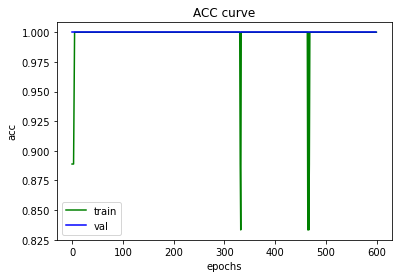

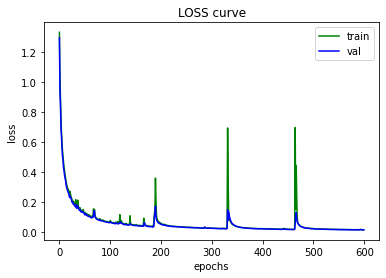

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:22
val size:5
test size:0
acc : t/v 0.7272727272727273 1.0
loss: t/v 1.2397337826815518 1.1838176250457764
acc : t/v 0.7272727272727273 1.0
loss: t/v 1.008682744069533 0.9046384572982789
acc : t/v 0.7272727272727273 1.0
loss: t/v 0.8666732500899922 0.7725150346755981
acc : t/v 0.9090909090909091 1.0
loss: t/v 0.7663557908751748 0.7595142364501953
acc : t/v 1.0 1.0
loss: t/v 0.7037633928385648 0.7738821387290955
acc : t/v 0.7272727272727273 1.0
loss: t/v 0.681939186020331 0.468629789352417
acc : t/v 0.9545454545454546 1.0
loss: t/v 0.5789058682593432 0.5784995913505554
acc : t/v 0.9090909090909091 1.0
loss: t/v 0.5455807853828777 0.4333412706851959
acc : t/v 1.0 1.0
loss: t/v 0.488789057189768 0.517354142665863
acc : t/v 0.8181818181818182 1.0
loss: t/v 0.5218032246286218 0.3357276737689972
acc : t/v 1.0 1.0
loss: t/v 0.4339676418087699 0.4550439238548279
acc : t/v 1.0 1.0
loss: t/v 0.39809373969381506 0.38615223169326784
acc : t/v 1.0 1.0
loss: t/v 0.3653751110488718 0.33203

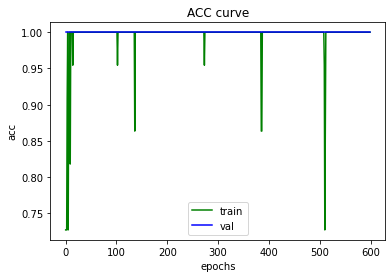

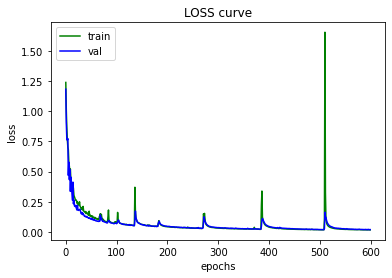

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:290: RuntimeWarning: invalid value encountered in double_scalars


train size:19
val size:5
test size:3
acc : t/v 0.6842105263157895 1.0
loss: t/v 1.4886463566830284 1.4494234085083009
acc : t/v 0.6842105263157895 1.0
loss: t/v 1.2217931370986135 1.1282710790634156
acc : t/v 0.8421052631578947 1.0
loss: t/v 1.052488204679991 1.0048837542533875
acc : t/v 1.0 1.0
loss: t/v 0.9223900562838504 0.9635930538177491
acc : t/v 0.9473684210526315 1.0
loss: t/v 0.8078431079262182 0.8013879656791687
acc : t/v 1.0 1.0
loss: t/v 0.7080060384775463 0.7729350686073303
acc : t/v 1.0 1.0
loss: t/v 0.6426995224074313 0.5773170351982116
acc : t/v 1.0 0.8
loss: t/v 0.5852444987548026 0.7417508602142334
acc : t/v 1.0 1.0
loss: t/v 0.5468914320594386 0.4654634058475494
acc : t/v 1.0 1.0
loss: t/v 0.46362385467479106 0.496127587556839
acc : t/v 1.0 1.0
loss: t/v 0.4108710555653823 0.40658012628555296
acc : t/v 1.0 1.0
loss: t/v 0.37428559911878484 0.35034783482551574
acc : t/v 1.0 1.0
loss: t/v 0.33914460241794586 0.3093033194541931
acc : t/v 1.0 1.0
loss: t/v 0.305533777726

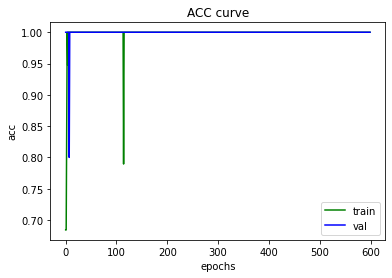

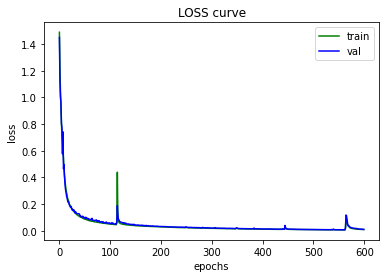

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:17
val size:5
test size:5
acc : t/v 0.9411764705882353 0.8
loss: t/v 1.405929263900308 1.5013379335403443
acc : t/v 0.7647058823529411 1.0
loss: t/v 1.1982506829149582 1.2376494646072387
acc : t/v 0.9411764705882353 1.0
loss: t/v 1.0548510621575748 1.1337092399597168
acc : t/v 1.0 0.8
loss: t/v 0.9637765884399414 1.1023414492607118
acc : t/v 0.7058823529411765 1.0
loss: t/v 0.9107340153525857 0.8558921217918396
acc : t/v 1.0 0.6
loss: t/v 0.8263168720638051 1.0196707487106322
acc : t/v 1.0 0.6
loss: t/v 0.7487592837389778 0.9749942660331726
acc : t/v 0.9411764705882353 1.0
loss: t/v 0.6948776069809409 0.7981008172035218
acc : t/v 1.0 0.4
loss: t/v 0.6429298116880304 0.9552833318710328
acc : t/v 1.0 0.8
loss: t/v 0.5973613437484292 0.8012582421302795
acc : t/v 1.0 1.0
loss: t/v 0.556381122154348 0.7347843289375305
acc : t/v 1.0 0.8
loss: t/v 0.5234660681556252 0.8390437006950379
acc : t/v 1.0 0.8
loss: t/v 0.49510318566771117 0.7634873747825622
acc : t/v 1.0 1.0
loss: t/v 0.4

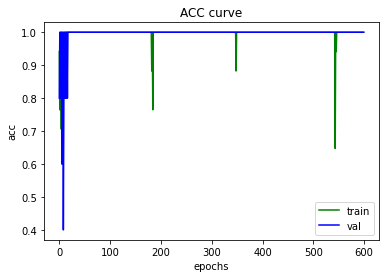

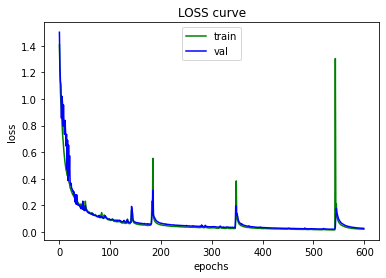

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:18
val size:4
test size:5
acc : t/v 0.9444444444444444 0.5
loss: t/v 1.376550747288598 1.5855478644371033
acc : t/v 1.0 0.75
loss: t/v 1.1345396902826097 1.372908502817154
acc : t/v 0.9444444444444444 1.0
loss: t/v 0.9977791044447157 1.1710414588451385
acc : t/v 1.0 0.0
loss: t/v 0.8845633301470015 1.377490073442459
acc : t/v 1.0 1.0
loss: t/v 0.7821688916948106 1.0930196642875671
acc : t/v 1.0 1.0
loss: t/v 0.7117107080088722 1.0071099996566772
acc : t/v 1.0 0.5
loss: t/v 0.6421538641055425 1.0534356236457825
acc : t/v 1.0 1.0
loss: t/v 0.5930492066674762 0.9417835772037506
acc : t/v 1.0 0.5
loss: t/v 0.5438155399428474 1.0264097601175308
acc : t/v 1.0 0.5
loss: t/v 0.5048588696453307 0.9555366039276123
acc : t/v 1.0 0.25
loss: t/v 0.47453563080893624 1.0439645946025848
acc : t/v 1.0 1.0
loss: t/v 0.48414523402849835 0.6572641730308533
acc : t/v 1.0 0.0
loss: t/v 0.4762235913011763 1.5632956624031067
acc : t/v 1.0 1.0
loss: t/v 0.43046344816684723 0.652647040784359
acc : t/

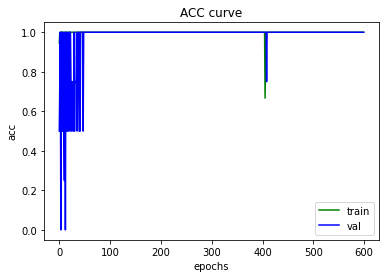

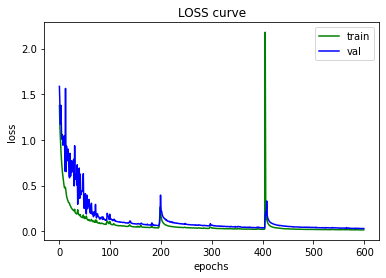

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:20
val size:5
test size:2
acc : t/v 0.8 1.0
loss: t/v 1.3419986963272095 1.2069149494171143
acc : t/v 0.8 1.0
loss: t/v 1.0770108073949813 0.9752017259597778
acc : t/v 0.9 1.0
loss: t/v 0.9090023696422577 0.8705059051513672
acc : t/v 0.95 1.0
loss: t/v 0.7867420986294746 0.7412550926208497
acc : t/v 0.95 1.0
loss: t/v 0.6950555384159088 0.6547120034694671
acc : t/v 0.95 1.0
loss: t/v 0.6204819172620774 0.601186066865921
acc : t/v 1.0 1.0
loss: t/v 0.5599009081721306 0.566793167591095
acc : t/v 1.0 1.0
loss: t/v 0.5166431427001953 0.507986056804657
acc : t/v 1.0 1.0
loss: t/v 0.4726198107004166 0.5570521950721741
acc : t/v 1.0 1.0
loss: t/v 0.43947751075029373 0.5222399055957794
acc : t/v 1.0 1.0
loss: t/v 0.4088219478726387 0.4895308017730713
acc : t/v 1.0 1.0
loss: t/v 0.3768612191081047 0.42344717383384706
acc : t/v 1.0 1.0
loss: t/v 0.36314588636159895 0.3550152897834778
acc : t/v 1.0 1.0
loss: t/v 0.3327376216650009 0.36827767491340635
acc : t/v 1.0 1.0
loss: t/v 0.32289

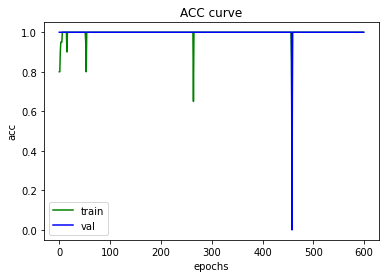

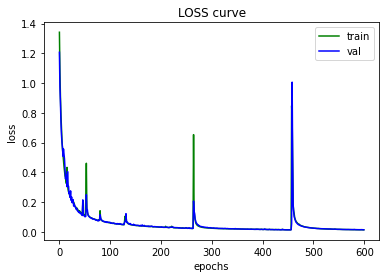

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:18
val size:5
test size:4
acc : t/v 0.8333333333333334 0.8
loss: t/v 1.350063681602478 1.4846256971359253
acc : t/v 1.0 0.8
loss: t/v 1.128682381576962 1.2373193025588989
acc : t/v 1.0 0.8
loss: t/v 0.9785351223415799 1.0943920016288757
acc : t/v 1.0 0.8
loss: t/v 0.8695978025595347 1.0152748107910157
acc : t/v 1.0 0.8
loss: t/v 0.7810699575477176 0.9730265021324158
acc : t/v 1.0 0.8
loss: t/v 0.6999216741985745 0.8727381587028503
acc : t/v 1.0 0.8
loss: t/v 0.6290544900629256 0.793703579902649
acc : t/v 1.0 1.0
loss: t/v 0.5829393631882138 0.7271971225738525
acc : t/v 1.0 0.8
loss: t/v 0.5357014073265923 0.8639747262001037
acc : t/v 1.0 1.0
loss: t/v 0.5063433100779852 0.6092474460601807
acc : t/v 1.0 0.8
loss: t/v 0.46342576709058547 0.7682123780250549
acc : t/v 1.0 0.8
loss: t/v 0.4340563764174779 0.730270779132843
acc : t/v 1.0 0.8
loss: t/v 0.4120461510287391 0.7429414033889771
acc : t/v 1.0 1.0
loss: t/v 0.3899546613295873 0.5726324319839478
acc : t/v 1.0 1.0
loss: t/v

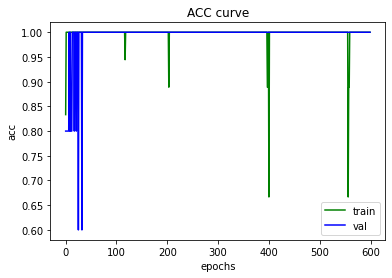

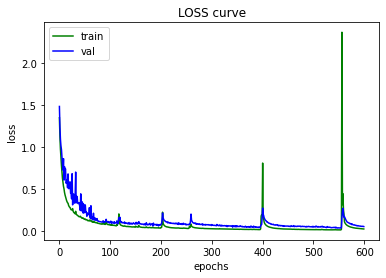

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

fold,iteration,macro,micro
1,0,0.5,1.0
8,0,0.0,0.0
6,0,0.0,nan
5,0,0.0,0.0
3,0,0.5,1.0
2,0,0.5,1.0
7,0,0.0,0.0
4,0,0.5,1.0
total,total,0.6357142857142857,0.6666666666666666

     N     E
N  4.0   3.0
E  6.0  14.0
--- 12013.020735025406 seconds ---
End!


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:293: RuntimeWarning: invalid value encountered in true_divide


In [0]:
#Needle passing with drop out
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/Regroup_LOUO/'
nb_epochs = 600
print("epochs setting: ", nb_epochs)
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Needle_Passing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
classes = ['N','E']
#classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 

#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)
validation_curve(surgery_type,reg = 0.00001,summary=False,max_itr=1)
#validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")

epochs setting:  1000
Number of different surgeries in total: 28
train size:18
val size:5
test size:4
acc : t/v 0.6666666666666666 1.0
loss: t/v 1.4832127922111087 1.2959841251373292
acc : t/v 0.6666666666666666 1.0
loss: t/v 1.242358922958374 1.1405242443084718
acc : t/v 0.6666666666666666 1.0
loss: t/v 1.0721389849980671 0.9598388314247132
acc : t/v 0.8333333333333334 1.0
loss: t/v 0.9484645326932272 0.8437134861946106
acc : t/v 1.0 1.0
loss: t/v 0.8532924950122833 0.7972914218902588
acc : t/v 1.0 1.0
loss: t/v 0.774543798632092 0.7494211912155151
acc : t/v 0.9444444444444444 1.0
loss: t/v 0.7146848506397672 0.628021878004074
acc : t/v 1.0 1.0
loss: t/v 0.6621509856647916 0.6776745736598968
acc : t/v 1.0 1.0
loss: t/v 0.607605967256758 0.542614471912384
acc : t/v 1.0 1.0
loss: t/v 0.5921223080820508 0.6615004777908325
acc : t/v 0.9444444444444444 1.0
loss: t/v 0.5577975577778287 0.43650866150856016
acc : t/v 1.0 1.0
loss: t/v 0.5853062470753988 0.6860173165798187
acc : t/v 1.0 1.0
lo

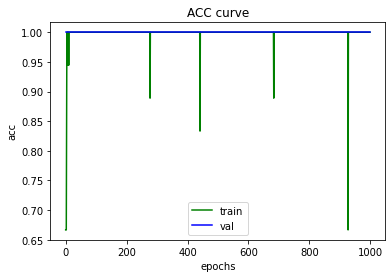

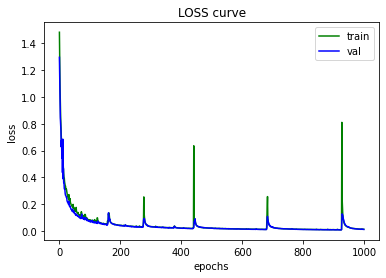

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:18
val size:5
test size:4
acc : t/v 0.8888888888888888 1.0
loss: t/v 1.2886794077025518 1.1838518261909485
acc : t/v 0.8888888888888888 1.0
loss: t/v 1.0304225550757513 0.9513203620910644
acc : t/v 0.8888888888888888 1.0
loss: t/v 0.8736497296227349 0.7700812458992005
acc : t/v 1.0 1.0
loss: t/v 0.7602072093221877 0.6797967672348022
acc : t/v 1.0 1.0
loss: t/v 0.6702080650462044 0.5963286101818085
acc : t/v 1.0 1.0
loss: t/v 0.6034920116265615 0.5350588798522949
acc : t/v 1.0 1.0
loss: t/v 0.5491681943337122 0.47789727449417113
acc : t/v 1.0 1.0
loss: t/v 0.5052793025970459 0.44343934655189515
acc : t/v 1.0 1.0
loss: t/v 0.4744538648260964 0.40888790488243104
acc : t/v 1.0 1.0
loss: t/v 0.4282526158624225 0.37304025888442993
acc : t/v 1.0 1.0
loss: t/v 0.40151593420240617 0.33897026181221007
acc : t/v 1.0 1.0
loss: t/v 0.3759004481964641 0.326432603597641
acc : t/v 1.0 1.0
loss: t/v 0.35257187816831803 0.3074623107910156
acc : t/v 1.0 1.0
loss: t/v 0.3378978181216452 0.29400

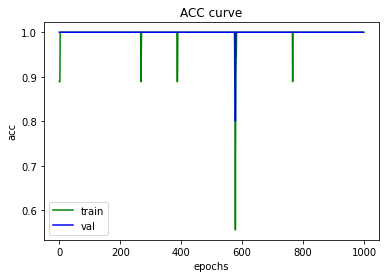

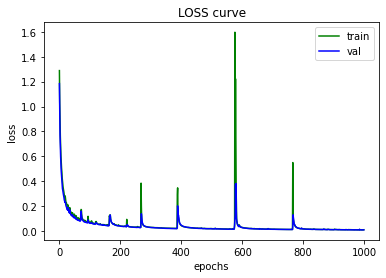

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

train size:22
val size:5
test size:0
acc : t/v 0.7272727272727273 1.0
loss: t/v 1.2908246029507031 1.2306736946105956
acc : t/v 0.9090909090909091 1.0
loss: t/v 1.064796594056216 1.1101227521896362
acc : t/v 0.7272727272727273 1.0
loss: t/v 0.9147661788897081 0.8647382616996765
acc : t/v 0.8636363636363636 1.0
loss: t/v 0.8015833036466078 0.7803087711334229
acc : t/v 1.0 0.8
loss: t/v 0.7188721922310916 0.8399239540100097
acc : t/v 1.0 1.0
loss: t/v 0.640925258398056 0.7083722829818726
acc : t/v 1.0 1.0
loss: t/v 0.5794560733166608 0.6791424512863159
acc : t/v 0.9090909090909091 1.0
loss: t/v 0.5699856823140924 0.5163481831550598
acc : t/v 1.0 1.0
loss: t/v 0.5436878082427111 0.6600782752037049
acc : t/v 0.9545454545454546 1.0
loss: t/v 0.5110230202024634 0.477277410030365
acc : t/v 1.0 1.0
loss: t/v 0.449108750982718 0.5727755784988403
acc : t/v 1.0 1.0
loss: t/v 0.4350931928916411 0.6415045320987701
acc : t/v 1.0 1.0
loss: t/v 0.4091456098990007 0.6055708825588226
acc : t/v 1.0 1.0
l

In [0]:
#Needle_Passing with no drop out
#time 
start_time = time.time()

# Global parameters 
root_dir = os.getcwd()+'/Data/jigsaws/'
path_to_configurations = os.getcwd()+'/Data/jigsaws/Experimental_setup/'
path_to_results = os.getcwd()+'/Regroup_LOUO/'
nb_epochs = 1000
print("epochs setting: ", nb_epochs)
#s_types = ['Suturing', 'Knot_Tying', 'Needle_Passing']
surgery_type = 'Needle_Passing'
dimensions_to_use = range(0,76)
number_of_dimensions= len(dimensions_to_use)
input_shape = (None,number_of_dimensions) # input is used to specify the value of the second dimension (number of variables) 
input_shapes = [[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)],[(None,3),(None,9),(None,3),(None,3),(None,1)]]
# for each manipulator   x,y,z  ,rot matrx, x'y'z' , a'b'g' , angle  , ... same for the second manipulator ...   

mapSurgeryDataBySurgeryName = collections.OrderedDict() # indexes surgery data (76 dimensions) by surgery name 
mapExpertiseLevelBySurgeryName = collections.OrderedDict() # indexes exerptise level by surgery name 
classes = ['N','E']
#classes = ['N','I','E']
nb_classes = len(classes)
confusion_matrix = pd.DataFrame(np.zeros(shape = (nb_classes,nb_classes)), index = classes, columns = classes ) # matrix used to calculate the JIGSAWS evaluation
encoder = LabelEncoder() # used to transform labels into binary one hot vectors 

surgeries_metadata = getMetaDataForSurgeries(surgery_type)

generateMaps(surgery_type)
print('Number of different surgeries in total: '+str(len(mapSurgeryDataBySurgeryName)))

# comment then uncommment the commented lines if you want to load a pre-trained model 

#validation(surgery_type,reg = 0.00001,summary=False,max_itr=1)
validation_curve(surgery_type,reg = 0.00001,summary=False,max_itr=1)
#validation_curve(surgery_type,reg = 0.0000001,summary=False,max_itr=1)

print(confusion_matrix)

print("--- %s seconds ---" % (time.time() - start_time))

print("End!")